## **Lending Club Case Study** 
**Team**: Suresh Narayanan, J Yeshaswini

### Business Understanding
You work for a consumer finance company which specialises in lending various types of loans to urban customers.
When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. 
Two types of risks are associated with the bank’s decision:
-   If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company
-   If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company


### Objective 

The Company wants to understand the reason for the default of the Loan by the Customer with the analysis and identify the key factors in deciding the approval/rejection of future Loan to the new customer applying for the Loan. Ex: The Variables which are the driving factor behind the default of Loan which will help the Company in their Portfolio and Risk Management.

In [1]:
# importing the required libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.core.display import HTML
%matplotlib inline
warnings.filterwarnings('ignore') # if there are any warning due to version mismatch, it will be ignored

In [9]:
# Lets explore the data stored in the local copy downloaded from the Case Study
loan= pd.read_csv("C:/Users/jekka/OneDrive/Desktop/Machine learning and AI/Database/loan/loan.csv")
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [11]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [13]:
loan.shape

(39717, 111)

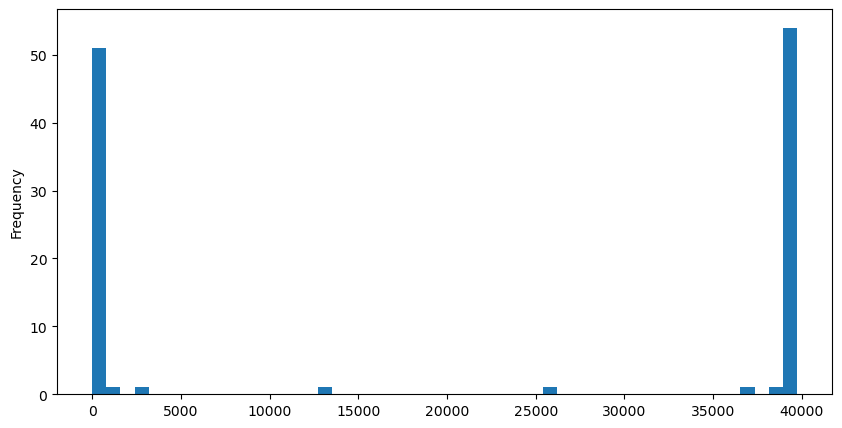

In [15]:
#columns have missing values and unique values, let see explore more to keep or drop them
#Lets cleanup of NULLs from rows and columns of the loan dataframe
col = loan.isnull().sum()
col.plot(kind='hist', bins=50, figsize = (10,5))
plt.show()

In the above figure, X-axis contains number of NULL values and Y-axis contains number of columns.
We can clearly see that there is a huge spike towards the 40K mark. The total records in our data is 39,717.
We would obviously not need the columns that have all NULLs. Also, we see there are few columns above 10K mark,
but let us analyze those before dropping.

In [18]:
col.loc[(col.values > 10000) & (col.values < 39717)].sort_values()

desc                      12942
mths_since_last_delinq    25682
mths_since_last_record    36931
next_pymnt_d              38577
dtype: int64

Let us drop all columns having above 10K NULL values in them.

In [21]:
loan.drop(columns=list(col[col.values > 10000].index), inplace=True)
loan.shape

(39717, 53)

In [23]:
r = loan.isnull().sum(axis=1) / len(loan.columns)
max(r.values)

0.09433962264150944

In [25]:
#Let see if there any columns with unique or single values
column_unique = loan.nunique()
print(column_unique)

id                            39717
member_id                     39717
loan_amnt                       885
funded_amnt                    1041
funded_amnt_inv                8205
term                              2
int_rate                        371
installment                   15383
grade                             7
sub_grade                        35
emp_title                     28820
emp_length                       11
home_ownership                    5
annual_inc                     5318
verification_status               3
issue_d                          55
loan_status                       3
pymnt_plan                        1
url                           39717
purpose                          14
title                         19615
zip_code                        823
addr_state                       50
dti                            2868
delinq_2yrs                      11
earliest_cr_line                526
inq_last_6mths                    9
open_acc                    

In [27]:
# There are many columns with single value. Let's drop them since no use for our analysis
# Here's the list of those column names
c1 = column_unique[column_unique.values == 1]
c1.index

Index(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'],
      dtype='object')

In [29]:
# now we'll drop those columns from our loan data
loan.drop(columns = list(c1.index), inplace=True)
loan.shape

(39717, 44)

In [31]:
#The company wants to know which loan applications are risky. 
#Hence the fields that are created after a loan application is approved doesn't make sense for our analysis
del_cols = ["id","member_id","url","zip_code","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv",
            "total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee",
            "last_pymnt_d","last_pymnt_amnt","last_credit_pull_d"]
loan.drop(columns=del_cols, inplace=True)
loan.shape

(39717, 28)

In [33]:
# Now we have the reduced data set with all the relevant columns
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             39717 non-null  int64  
 1   funded_amnt           39717 non-null  int64  
 2   funded_amnt_inv       39717 non-null  float64
 3   term                  39717 non-null  object 
 4   int_rate              39717 non-null  object 
 5   installment           39717 non-null  float64
 6   grade                 39717 non-null  object 
 7   sub_grade             39717 non-null  object 
 8   emp_title             37258 non-null  object 
 9   emp_length            38642 non-null  object 
 10  home_ownership        39717 non-null  object 
 11  annual_inc            39717 non-null  float64
 12  verification_status   39717 non-null  object 
 13  issue_d               39717 non-null  object 
 14  loan_status           39717 non-null  object 
 15  purpose            

In [39]:
#Let us look at data columns-wise for our analysis one by one and see how it can infulence our decision manking


In [35]:
# Lets Start with loan_status
loan['loan_status'].value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Current         1140
Name: count, dtype: int64

In [37]:
#Since loan status "Current" doesnt give any info for our analysis for approving or rejecting application. lets drop this data
loan = loan[~(loan['loan_status'] == 'Current')]
loan.shape

(38577, 28)

In [41]:
# Term
loan['term'].value_counts()

term
36 months    29096
60 months     9481
Name: count, dtype: int64

In [132]:
# Lets remove the months an make it a int category
loan['term'] = loan['term'].apply(lambda x: pd.to_numeric(x.split("months")[0]))


In [43]:
# int_rate
loan['int_rate'].head()


0    10.65%
1    15.27%
2    15.96%
3    13.49%
5     7.90%
Name: int_rate, dtype: object

In [45]:
# Lets remove percentage from the list
loan['int_rate'] = loan['int_rate'].apply(lambda x: pd.to_numeric(x.split("%")[0]))
loan['int_rate'].describe()

count    38577.000000
mean        11.932219
std          3.691327
min          5.420000
25%          8.940000
50%         11.710000
75%         14.380000
max         24.400000
Name: int_rate, dtype: float64

<Axes: >

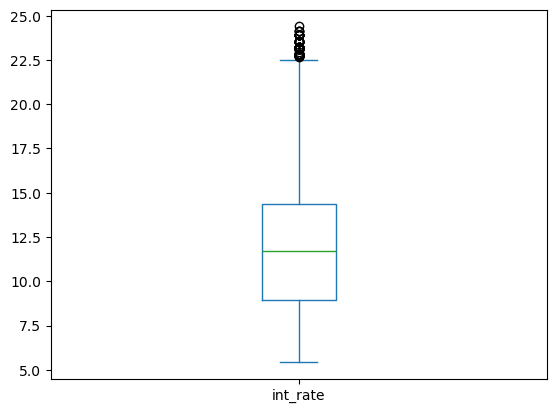

In [47]:
loan['int_rate'].plot.box()

In [49]:
# We need to analyse the Outliner value during our Univariate analysis

In [51]:
loan['grade'].value_counts()

grade
B    11675
A    10045
C     7834
D     5085
E     2663
F      976
G      299
Name: count, dtype: int64

In [53]:
loan['sub_grade'].value_counts()

sub_grade
A4    2873
B3    2825
A5    2715
B5    2615
B4    2437
C1    2055
B2    2001
C2    1931
A3    1810
B1    1797
A2    1508
C3    1488
D2    1286
C4    1206
C5    1154
A1    1139
D3    1116
D1     931
D4     918
D5     834
E1     722
E2     614
E3     516
E4     424
E5     387
F1     305
F2     233
F3     174
F4     151
F5     113
G1      94
G2      77
G4      54
G3      45
G5      29
Name: count, dtype: int64

In [55]:
print(loan['emp_title'].value_counts().head())
print(loan['emp_title'].unique().shape)

emp_title
US Army              131
Bank of America      107
IBM                   65
AT&T                  57
Kaiser Permanente     56
Name: count, dtype: int64
(28028,)


In [57]:
loan['emp_length'].unique()

array(['10+ years', '< 1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '1 year', '6 years', '2 years', '7 years',
       nan], dtype=object)

In [59]:
loan['emp_length'].isnull().sum()

1033

In [61]:
loan['home_ownership'].value_counts()

home_ownership
RENT        18480
MORTGAGE    17021
OWN          2975
OTHER          98
NONE            3
Name: count, dtype: int64

In [63]:
loan['verification_status'].value_counts()

verification_status
Not Verified       16694
Verified           12206
Source Verified     9677
Name: count, dtype: int64

In [65]:
loan['issue_d'].head()

0    Dec-11
1    Dec-11
2    Dec-11
3    Dec-11
5    Dec-11
Name: issue_d, dtype: object

In [73]:
# Now lets split the Month and Year in the list
loan[['issue_m', 'issue_y']] = loan['issue_d'].str.split('-', expand=True)
loan.issue_y.value_counts()

year
11    20516
10    11532
09     4716
08     1562
07      251
Name: count, dtype: int64

In [75]:
loan.issue_m.value_counts()

issue_m
Dec    4215
Nov    4006
Oct    3761
Sep    3498
Aug    3388
Jul    3351
Jun    3180
May    2919
Apr    2831
Mar    2691
Jan    2379
Feb    2358
Name: count, dtype: int64

In [83]:
# drop this issue_d column

loan.drop(columns=['issue_d'], inplace=True)
loan.head()


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,issue_m,issue_y
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,...,Jan-85,1,3,0,13648,83.70%,9,0.0,Dec,11
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,...,Apr-99,5,3,0,1687,9.40%,4,0.0,Dec,11
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,...,Nov-01,2,2,0,2956,98.50%,10,0.0,Dec,11
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,Feb-96,1,10,0,5598,21%,37,0.0,Dec,11
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,...,Nov-04,3,9,0,7963,28.30%,12,0.0,Dec,11


In [85]:
loan['purpose'].value_counts()

purpose
debt_consolidation    18055
credit_card            5027
other                  3865
home_improvement       2875
major_purchase         2150
small_business         1754
car                    1499
wedding                 926
medical                 681
moving                  576
vacation                375
house                   367
educational             325
renewable_energy        102
Name: count, dtype: int64

In [87]:
len(loan['title'].value_counts())

19297

In [89]:
loan['title'].head(10)

0                                  Computer
1                                      bike
2                      real estate business
3                                  personel
5     My wedding loan I promise to pay back
6                                      Loan
7                           Car Downpayment
8      Expand Business & Buy Debt Portfolio
9               Building my credit history.
10               High intrest Consolidation
Name: title, dtype: object

In [91]:
# We'll drop this column as it is a descriptive attribute that won't serve our analysis
loan.drop(columns=['title'], inplace=True)

In [93]:
loan['addr_state'].value_counts()

addr_state
CA    6949
NY    3698
FL    2781
TX    2659
NJ    1790
IL    1478
PA    1468
VA    1369
GA    1359
MA    1297
OH    1178
MD    1023
AZ     849
WA     818
CO     766
NC     750
CT     726
MI     704
MO     670
MN     605
NV     479
SC     459
WI     440
AL     435
OR     435
LA     427
KY     311
OK     287
KS     255
UT     252
AR     235
DC     211
RI     194
NM     183
WV     172
NH     166
HI     166
DE     113
MT      83
WY      80
AK      78
SD      62
VT      53
MS      19
TN      17
IN       9
ID       6
IA       5
NE       5
ME       3
Name: count, dtype: int64

In [95]:
loan['earliest_cr_line'].value_counts()

earliest_cr_line
Oct-99    360
Nov-98    357
Oct-00    341
Dec-98    340
Dec-97    318
         ... 
Nov-65      1
Feb-73      1
Oct-08      1
Dec-61      1
Oct-74      1
Name: count, Length: 524, dtype: int64

In [97]:
loan[['month', 'year']] = loan['earliest_cr_line'].str.split('-', expand=True)
loan.year.value_counts()

year
00    3160
99    2896
98    2773
01    2462
97    2387
96    2202
95    2078
94    1948
02    1890
03    1813
04    1727
05    1467
93    1460
06    1154
92    1029
90    1005
91     945
89     834
88     709
07     698
87     590
86     478
85     439
84     395
83     322
82     215
81     181
80     175
78     161
79     157
08     153
77     112
76      93
75      83
74      62
73      61
72      49
70      47
71      45
69      37
68      19
67      18
66      11
63      10
65       8
64       6
62       5
54       2
61       2
59       1
56       1
46       1
50       1
Name: count, dtype: int64

In [99]:

# The earliest_cr_line field contains data format inconsistencies, displaying dates in both MMM-YY and YY-MMM formats. 
# Additionally, the year is represented with two digits instead of being Y2K-compliant. 
# Consequently, we will need to implement some logic to extract meaningful data from this field.


from datetime import datetime
today = datetime.today()
today.year

2024

In [101]:

def days_from_earliest_cr_line (d):
    m, y = d.split('-')
    if y in ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']:
        y, m = d.split('-')
    y = 2000 + int(y)
    if y > today.year:
        y -= 100
    earliest_cr_line = datetime.strptime(str(y)+'-'+m+'-1', '%Y-%b-%d')
    return (today - earliest_cr_line).days
days_from_earliest_cr_line("Dec-20")

1363

In [103]:
loan['days_from_earliest_cr_line'] = loan['earliest_cr_line'].apply(days_from_earliest_cr_line)
loan['days_from_earliest_cr_line'].describe()

count    38577.000000
mean     10063.981647
std       2491.854695
min       5776.000000
25%       8394.000000
50%       9613.000000
75%      11225.000000
max      28726.000000
Name: days_from_earliest_cr_line, dtype: float64

In [105]:
# Now that we have a new column days_from_earliest_cr_line we can get rid of earliest_cr_line
loan.drop(columns=['earliest_cr_line'], inplace=True)

In [107]:
loan['revol_util'].head()

0    83.70%
1     9.40%
2    98.50%
3       21%
5    28.30%
Name: revol_util, dtype: object

In [109]:
#let us convert these values in numberics by removing %
loan['revol_util'] = pd.Series(loan['revol_util']).str.replace('%', '').astype(float)
loan['revol_util'].describe()

count    38527.000000
mean        48.702777
std         28.364741
min          0.000000
25%         25.200000
50%         49.100000
75%         72.300000
max         99.900000
Name: revol_util, dtype: float64

In [111]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38577 entries, 0 to 39716
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   38577 non-null  int64  
 1   funded_amnt                 38577 non-null  int64  
 2   funded_amnt_inv             38577 non-null  float64
 3   term                        38577 non-null  object 
 4   int_rate                    38577 non-null  float64
 5   installment                 38577 non-null  float64
 6   grade                       38577 non-null  object 
 7   sub_grade                   38577 non-null  object 
 8   emp_title                   36191 non-null  object 
 9   emp_length                  37544 non-null  object 
 10  home_ownership              38577 non-null  object 
 11  annual_inc                  38577 non-null  float64
 12  verification_status         38577 non-null  object 
 13  loan_status                 38577 no

In [113]:
loan.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,days_from_earliest_cr_line
count,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,3.857700e+04,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38527.000000,38577.000000,37880.000000,38577.000000
mean,11047.025430,10784.058506,10222.481123,11.932219,322.466318,6.877797e+04,13.272727,0.146668,0.871737,9.275423,0.055422,13289.489826,48.702777,22.052648,0.043479,10063.981647
std,7348.441646,7090.306027,7022.720644,3.691327,208.639215,6.421868e+04,6.673044,0.492271,1.071546,4.401588,0.237804,15866.492241,28.364741,11.425861,0.204583,2491.854695
min,500.000000,500.000000,0.000000,5.420000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,5776.000000
25%,5300.000000,5200.000000,5000.000000,8.940000,165.740000,4.000000e+04,8.130000,0.000000,0.000000,6.000000,0.000000,3650.000000,25.200000,13.000000,0.000000,8394.000000
50%,9600.000000,9550.000000,8733.440000,11.710000,277.860000,5.886800e+04,13.370000,0.000000,1.000000,9.000000,0.000000,8762.000000,49.100000,20.000000,0.000000,9613.000000
75%,15000.000000,15000.000000,14000.000000,14.380000,425.550000,8.200000e+04,18.560000,0.000000,1.000000,12.000000,0.000000,16912.000000,72.300000,29.000000,0.000000,11225.000000
max,35000.000000,35000.000000,35000.000000,24.400000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,44.000000,4.000000,149588.000000,99.900000,90.000000,2.000000,28726.000000


## EDA
Our Dataset is now ready for Exploratory Data Analysis

A correlation matrix is a valuable tool for understanding the relationships between variables in your dataset. Let us now draw a correlation matrix on our data to better understand our data.

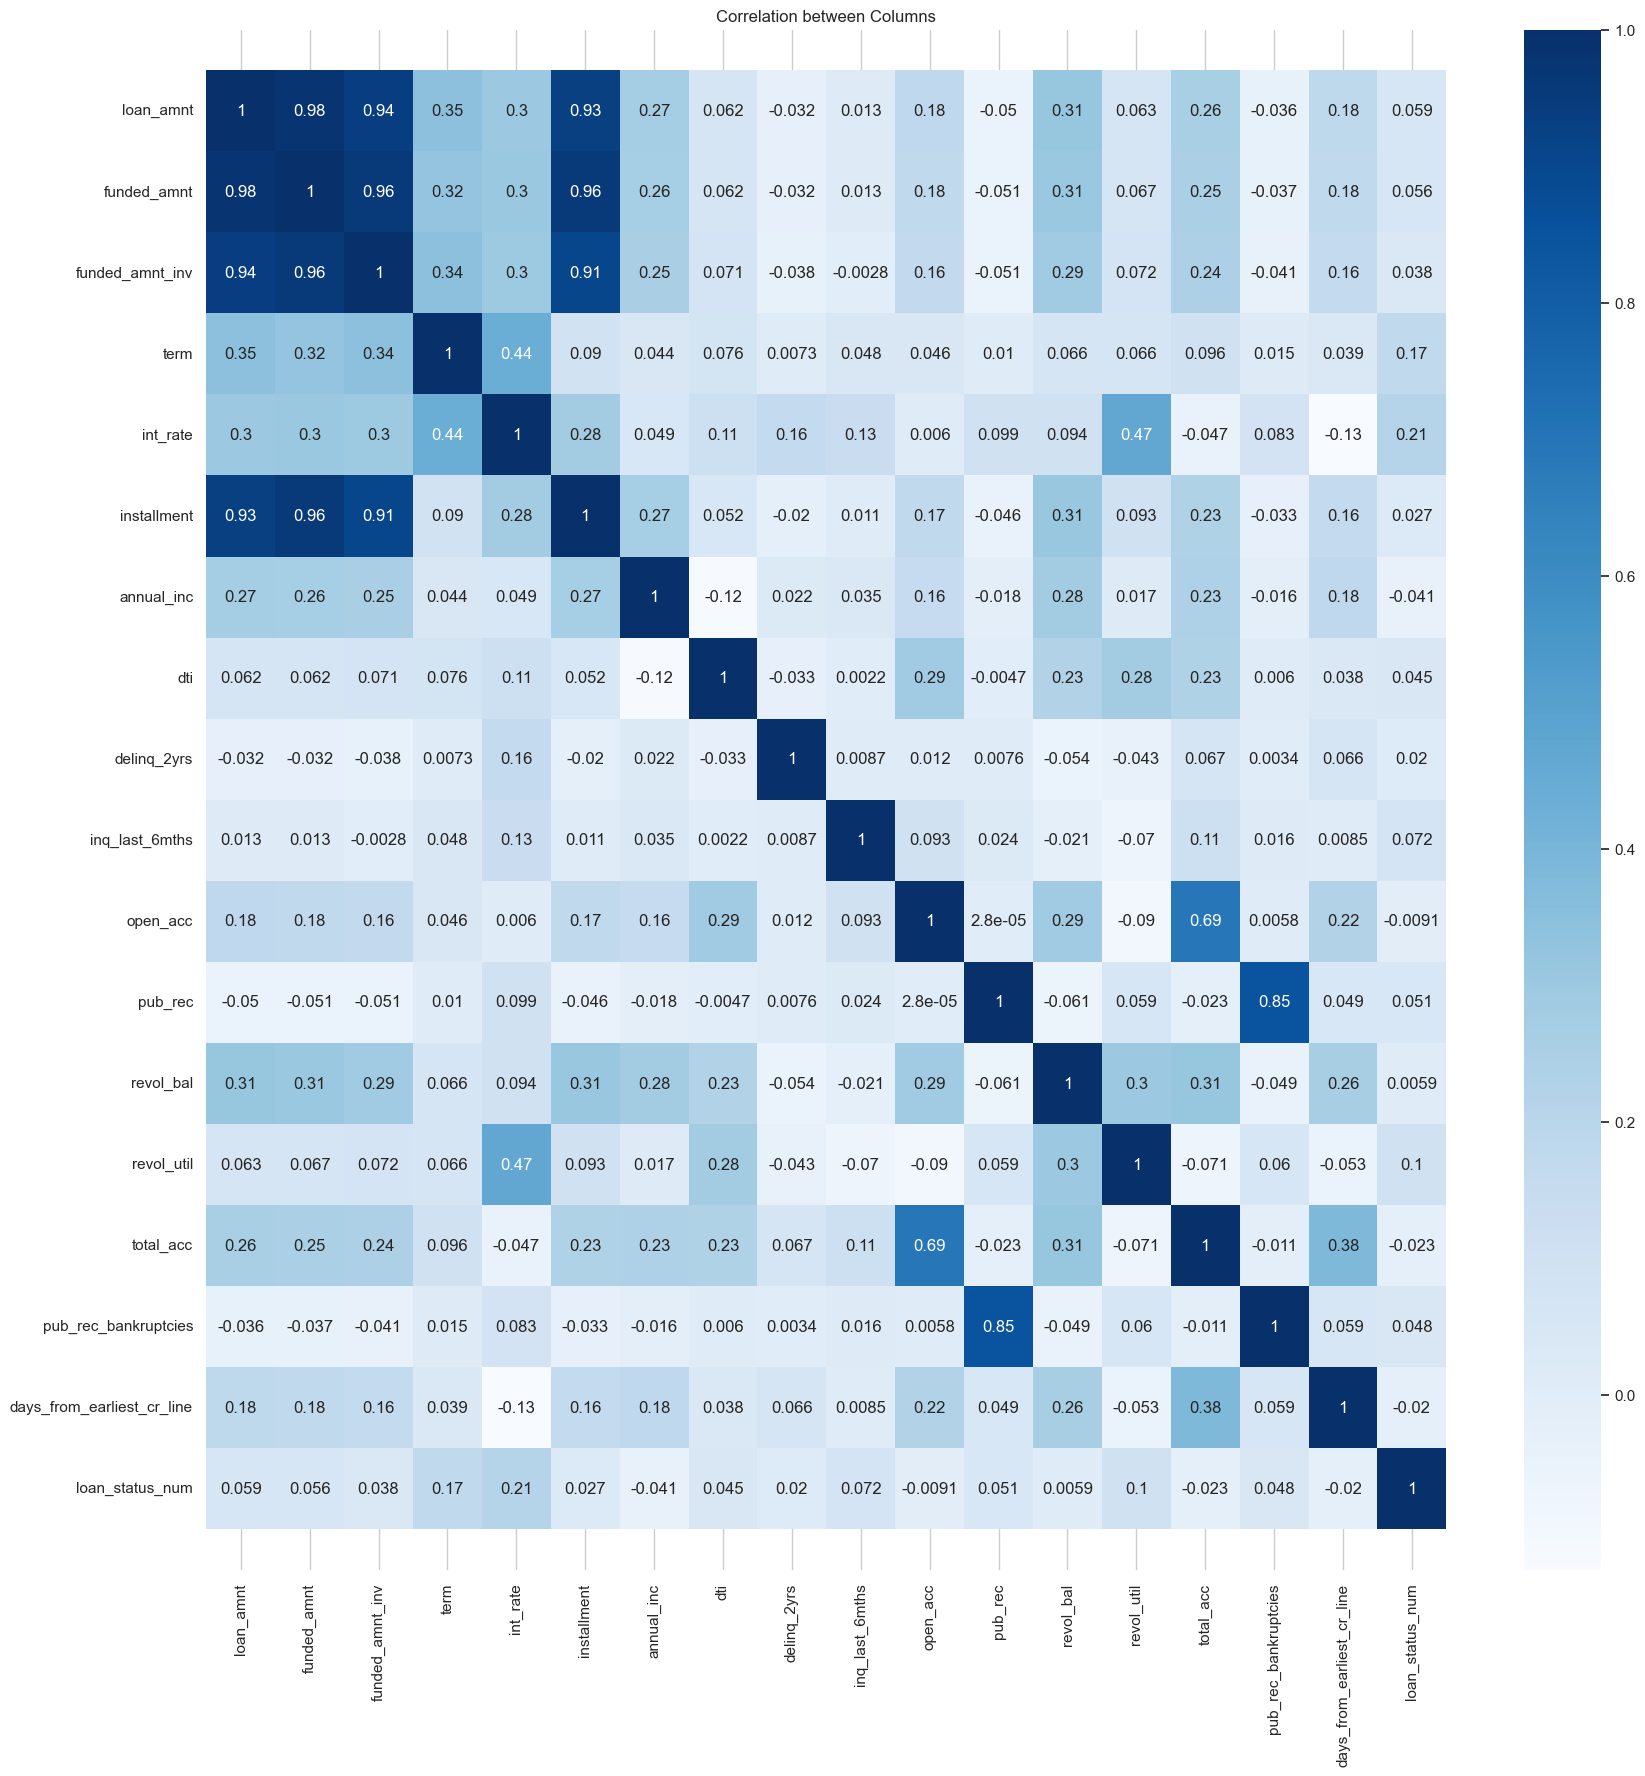

In [158]:
#Finding correlation matric

numeric_df = loan.select_dtypes(include=[float, int])

corr_matrix = numeric_df.corr()
plt.figure(figsize=(20,20))
#plotting correlatioon matric on a heat map
ax = sns.heatmap(corr_matrix, annot = True, cmap='Blues')
top, bottom = ax.get_ylim()
ax.set_ylim(top+0.5, bottom-0.5)
plt.title("Correlation between Columns")
plt.show()

Given that darker values indicate stronger correlations, it's evident that loan_amnt, funded_amnt, funded_amnt_inv, and installment exhibit significant correlations with each other, reflecting their proportional relationship. Additionally, there is a notable correlation among public records-related fields such as pub_rec and pub_rec_bankrupcies, as well as among account-related fields like open_acc and total_acc.

### Univariate Analysis
#### 1. Loan Status
> (Current status of the loan.) This is our predicting variable. We won't have to perform analysis on this variable but it is our determining attribute. So we'll understand it first


In [116]:
# First we'll take the percentage of loans paid vs charged off for all the records
loan_status_percent = loan['loan_status'].value_counts(normalize=True)
loan_status_percent

loan_status
Fully Paid     0.854136
Charged Off    0.145864
Name: proportion, dtype: float64

In [124]:
# Let's create a numeric attribute based on loan_status. Where 1 for defaulted loans and 0 for paid off
loan['loan_status_num'] = loan['loan_status'].apply(lambda x: 1 if x=='Charged Off' else 0)

In [130]:
loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,issue_m,issue_y,month,year,days_from_earliest_cr_line,loan_status_num
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,...,13648,83.7,9,0.0,Dec,11,Jan,85,14481,0
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,...,1687,9.4,4,0.0,Dec,11,Apr,99,9278,1
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,...,2956,98.5,10,0.0,Dec,11,Nov,01,8333,0
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,5598,21.0,37,0.0,Dec,11,Feb,96,10433,0
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,...,7963,28.3,12,0.0,Dec,11,Nov,04,7237,0


<Axes: xlabel='loan_status'>

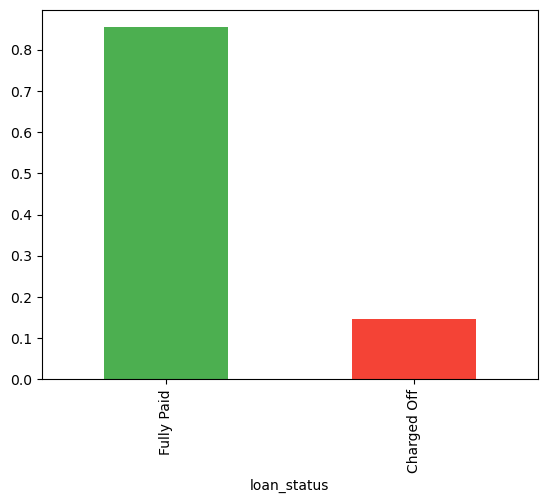

In [122]:
# Visually representing the percentage of records that were charged off versus fully paid
loan_status_percent.plot(kind='bar', color=['#4CAF50', '#F44336'])

**Observation:** We can see that about 15 percent of the people have defaulted

#### 2. Loan Amount
(The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.) 

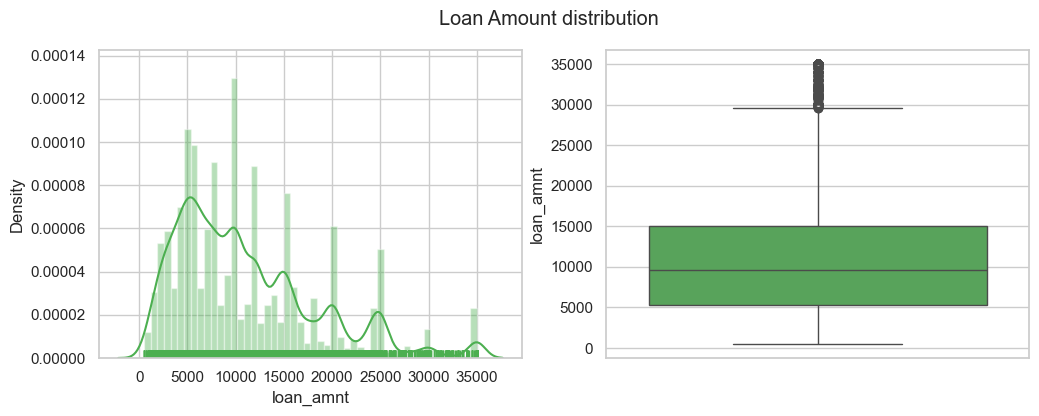

In [144]:
#Increasing the figure size of plot
plt.figure(figsize=(12,4))
#Setting subplot index
plt.subplot(1,2,1)
#Histogram plot
sns.distplot(a=loan.loan_amnt, rug=True)
plt.subplot(1,2,2)
#Box plot
sns.boxplot(data=loan.loan_amnt)
#Single title for both subplots.
plt.suptitle('Loan Amount distribution')
plt.show()

In [166]:
loan['loan_amnt'].describe()

count    38577.000000
mean     11047.025430
std       7348.441646
min        500.000000
25%       5300.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

Let us now write some useful functions that can be used for our univariate analyses.

In [169]:
# The PercentileCut function is designed to categorize a continuous numeric column in a DataFrame into percentiles 
# and create a new column with these categories.
# Creates Percentile Ranges, Generates Labels for Percentiles, Creates a New Column
#--------------------------------------------------------------------------------------------------------------------


def PercentileCut (*, data=loan, column, trailer=''):
    """
        Parameters:
            data : defaulted to 'loan'
            column : this is the continuous numeric field which has to be binned to its percentiles
            trailer : defaulted to blank, this will be added to the end of the percentile values
                      like '%' for interest rate related fields
        Returns:
            None
            It creates a new column in the data with a suffix '_p' and this contains the newly created category
    """
    new_column = column + '_p'
    labels = ['Lowest ','Lower ','Medium ','Higher ','Highest ']
    labels = [labels[p] + '(' +
              str(round(np.nanpercentile(data[column], p * 20),2)) +
              trailer + ' - ' +
              str(round(np.nanpercentile(data[column], (p+1) * 20),2)) +
              trailer + ')'
              for p in range(5)]
    data[new_column] = pd.qcut(data[column], q=5, labels=labels)

In [171]:
# the Univariate_Categorical function helps in visualizing and analyzing the distribution of a categorical variable and
# its relationship with defaulted loans, providing both graphical and tabular representations for better understanding.

def Univariate_Categorical (*, data=loan, column, title=None, figsize=(8,6), grp_comparison=True, box_plot=False,
                            pct_comparison=False, filter=None, disp_filter = None):
    """
        Parameters:
            data : defaulted at the 'loan' variable, but can be changed externally if needed
            column : need to provide the numerical column for comparison
            figsize : a default have is given, but can be overridden
            loan_status_pct : a global variable, which is referred here for the percentage comparison
            grp_comparison : with this as true, it groups the data based on the categories and compares
            pct_comparison : this will call the Pct_Comparison method and below couple parameters will be applicable for it
            filter : any conditions based on which the data will be filtered before plotting, ignored if None
            disp_filter : string for display purpose only, valid if filter is not None
        Returns:
            None, does a countplot and a box plot as well, if needed
    """
    plotdata = data if filter is None else data.loc[filter]
        
    if pct_comparison and filter is not None:
        Pct_Comparison(filter, disp_filter)

    if grp_comparison:
        fig, ax = plt.subplots(figsize=figsize)
        sns.countplot(data=plotdata, y=column, hue=by, ax=ax, 
                      order=plotdata[column].value_counts().index, hue_order=order)
        if title is not None:
            plt.title(title)
        plt.show()
        
        df = loan.groupby([column])[by].value_counts(normalize=True
                                                    ).rename('Charged off %').reset_index().sort_values(column)
        df = df.loc[df[by]=='Charged Off'].sort_values(by='Charged off %', ascending=False).drop(columns=[by])
        df2 = loan.groupby([column])[by].count()
        df = df.merge(right=df2,on=column).rename(columns={by:'Record count'})
        display(HTML(df.to_html(index=False)))
        
        if box_plot:
            df2.plot(kind='box',logy=True,x="No. of records of defaulted loans per category")
            plt.show()        

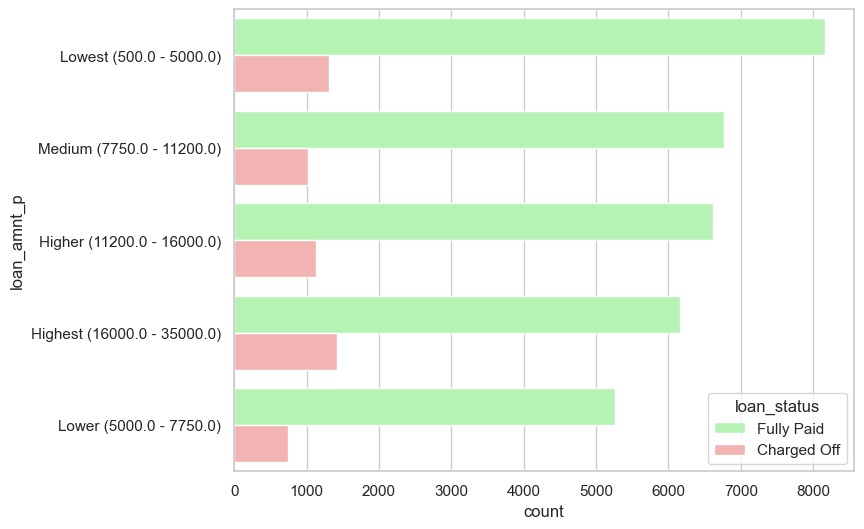

loan_amnt_p,Charged off %,Record count
Highest (16000.0 - 35000.0),0.187624,7579
Higher (11200.0 - 16000.0),0.145368,7739
Lowest (500.0 - 5000.0),0.138725,9472
Medium (7750.0 - 11200.0),0.131613,7788
Lower (5000.0 - 7750.0),0.123521,5999


In [173]:
PercentileCut(column='loan_amnt')
Univariate_Categorical(column='loan_amnt_p')

**Observations:** 
-  We can observe that the median, as in most number of people have taken loans for 10000. And the data distribution shows that very few people have taken loans above 30000
-  Higher the loan amount, greater the chance of the loan getting default.

#### 3. Int rate
(Interest Rate on the loan)

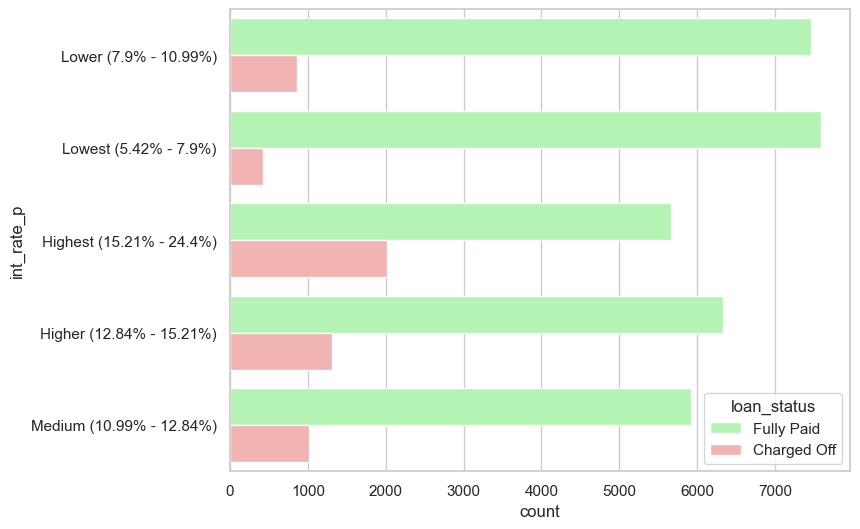

int_rate_p,Charged off %,Record count
Highest (15.21% - 24.4%),0.262150,7675
Higher (12.84% - 15.21%),0.171619,7639
Medium (10.99% - 12.84%),0.146995,6939
Lower (7.9% - 10.99%),0.102876,8311
Lowest (5.42% - 7.9%),0.053538,8013


In [178]:
PercentileCut(column='int_rate', trailer='%')
Univariate_Categorical(column='int_rate_p')

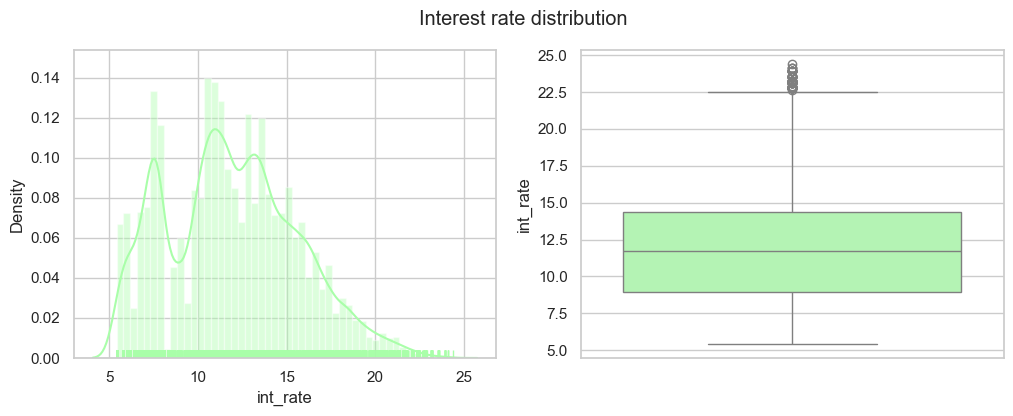

In [184]:
#Increasing the figure size of plot
plt.figure(figsize=(12,4))
#Setting subplot index
plt.subplot(1,2,1)
#Histogram plot
sns.distplot(a=loan.int_rate, rug=True)
plt.subplot(1,2,2)
#Box plot
sns.boxplot(data=loan.int_rate)
#Single title for both subplots.
plt.suptitle('Interest rate distribution')
plt.show()

**Observations**:<br>
-  From the above 2 plots and statistics of interest rates we can conclude that most of the interest rates lies between **9% to 14.5%**. Some people took loan at higher rates of interest i.e., **22.5%**
-  Higher the interest rate leads to higher charged off%



#### 4. installment
(The monthly payment owed by the borrower if the loan originates.)

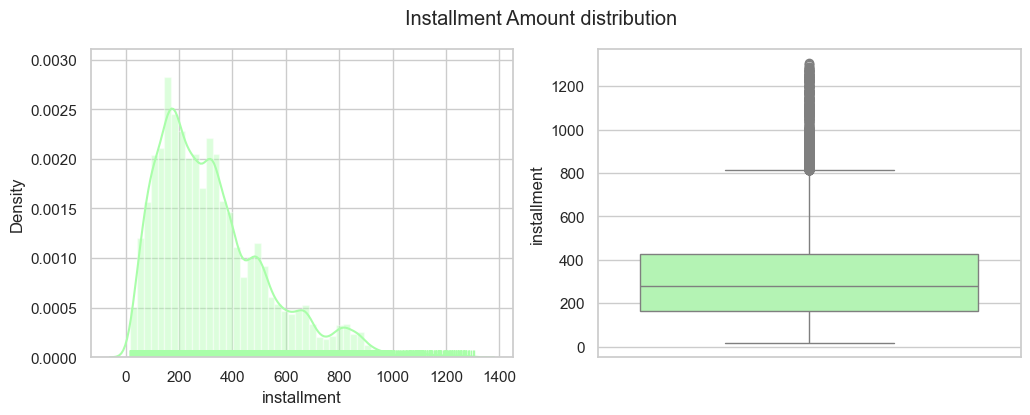

In [188]:
installment = loan.installment
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(a=installment, rug=True)
plt.subplot(1,2,2)
sns.boxplot(data=installment)
plt.suptitle('Installment Amount distribution')
plt.show()

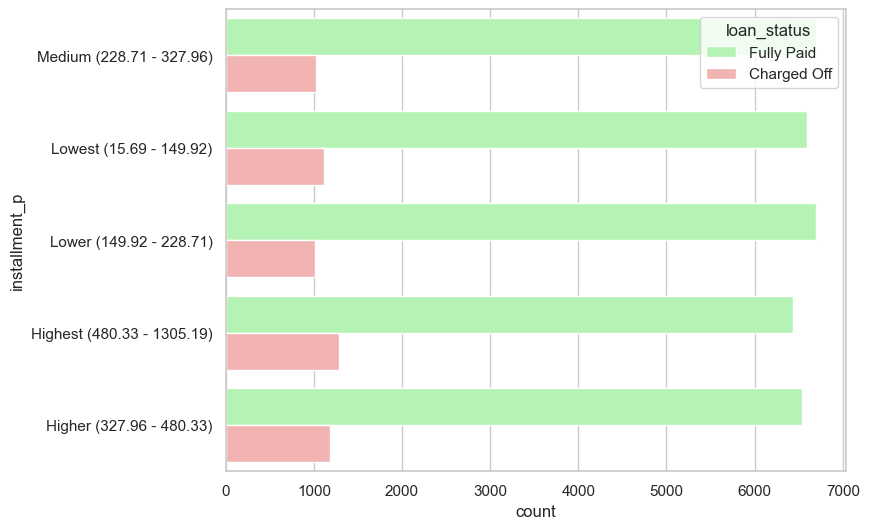

installment_p,Charged off %,Record count
Highest (480.33 - 1305.19),0.166321,7714
Higher (327.96 - 480.33),0.152988,7713
Lowest (15.69 - 149.92),0.145153,7716
Medium (228.71 - 327.96),0.132936,7718
Lower (149.92 - 228.71),0.131934,7716


In [190]:
PercentileCut(column='installment')
Univariate_Categorical(column='installment_p')

**Observations**:<br>
-  The Most representative value of Installment amount in around 280.
-  Above data and plot shows that higher installment amounts shows higher default percentages.



#### 5. annual_inc
(The self-reported annual income provided by the borrower during registration.)

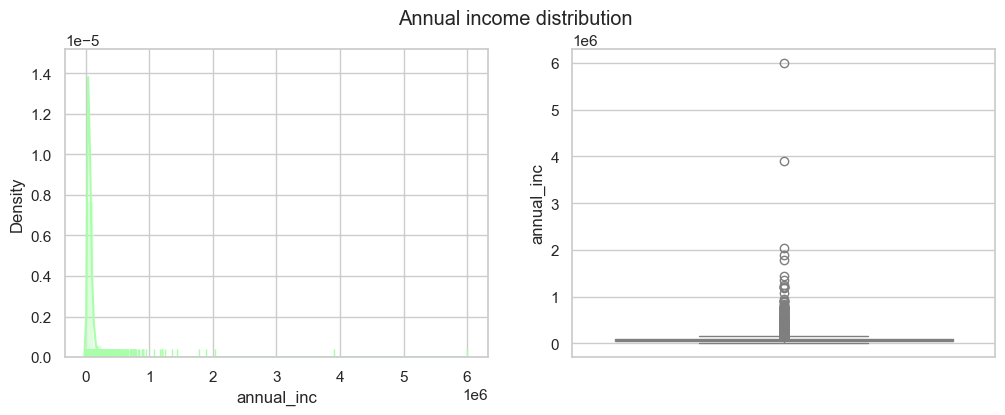

In [196]:
var1 = loan.annual_inc
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(a=var1, rug=True)
plt.subplot(1,2,2)
sns.boxplot(data=var1)
plt.suptitle('Annual income distribution')
plt.show()

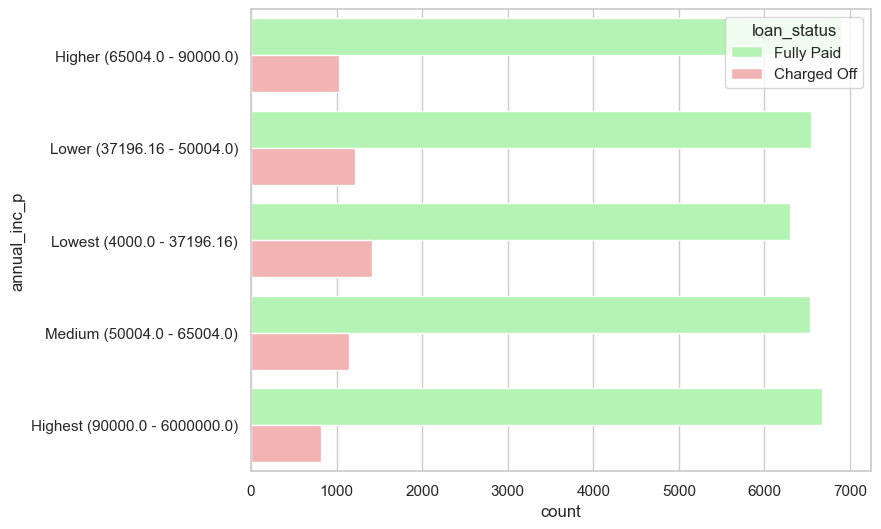

annual_inc_p,Charged off %,Record count
Lowest (4000.0 - 37196.16),0.183126,7716
Lower (37196.16 - 50004.0),0.156926,7768
Medium (50004.0 - 65004.0),0.149629,7679
Higher (65004.0 - 90000.0),0.129651,7929
Highest (90000.0 - 6000000.0),0.109285,7485


In [198]:
PercentileCut(column='annual_inc')
Univariate_Categorical(column='annual_inc_p')

**Observations**:<br>
-  Around 361 people are having more the 235000 annual income. and 99% of people are having incomes below 235000.
-  Higher the income higher the repayment %

#### 6. dti
(A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.)

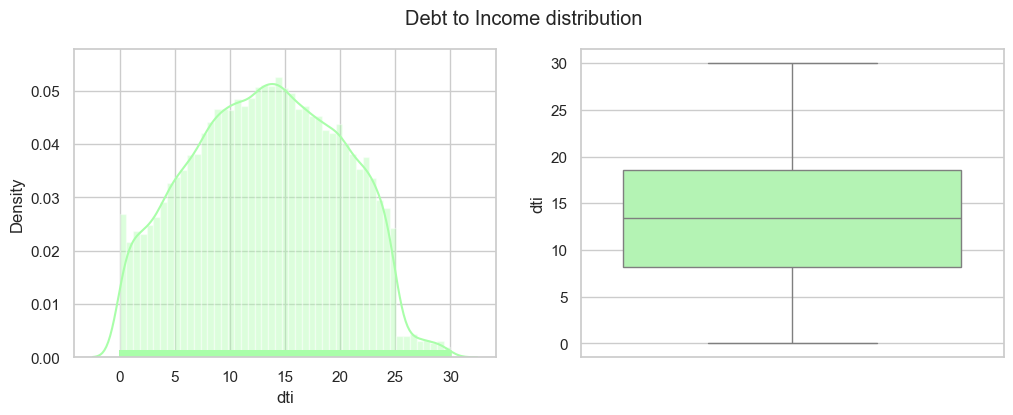

In [208]:
var1 = loan.dti

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(a=var1, rug=True)
plt.subplot(1,2,2)
sns.boxplot(data=var1)
plt.suptitle('Debt to Income distribution')
plt.show()

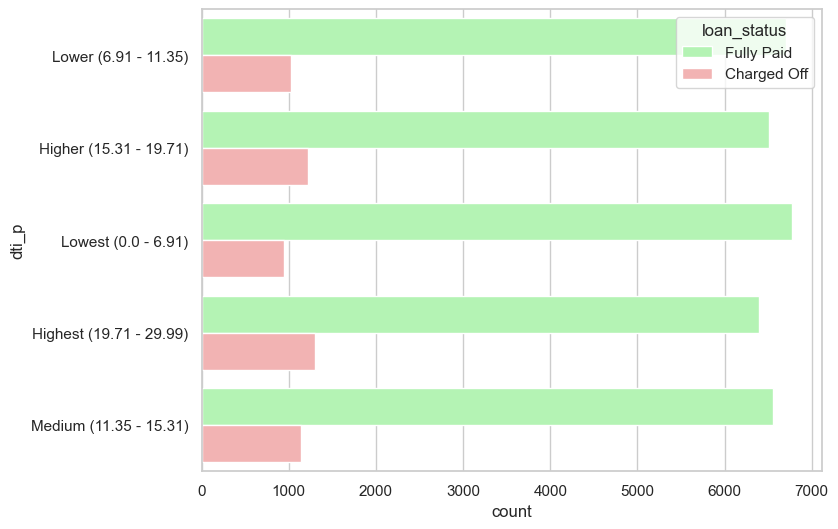

dti_p,Charged off %,Record count
Highest (19.71 - 29.99),0.168853,7699
Higher (15.31 - 19.71),0.157908,7726
Medium (11.35 - 15.31),0.147609,7696
Lower (6.91 - 11.35),0.132627,7736
Lowest (0.0 - 6.91),0.122409,7720


In [210]:
PercentileCut(column='dti')
Univariate_Categorical(column='dti_p')

**Observations**:<br>
-  Looks like there are no outliers and the distribution is very much similar to normal distribution.
This is good sign that all the loans are given to barrower's who have Debt to Income ration less than 30.
-  higher DTI ( debt to income ratio) will lead to higher charged off %

#### 7. revol_bal
(Total credit revolving balance)

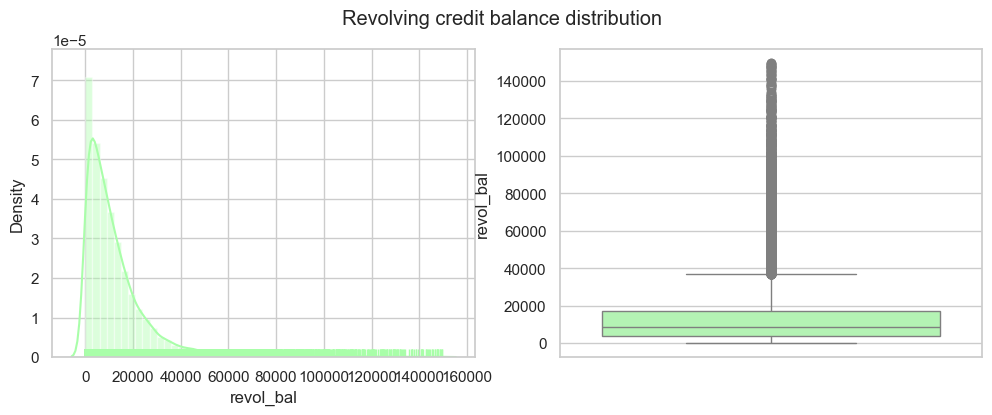

In [214]:
var1 = loan.revol_bal

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(a=var1, rug=True)
plt.subplot(1,2,2)
sns.boxplot(data=var1)
plt.suptitle('Revolving credit balance distribution')
plt.show()

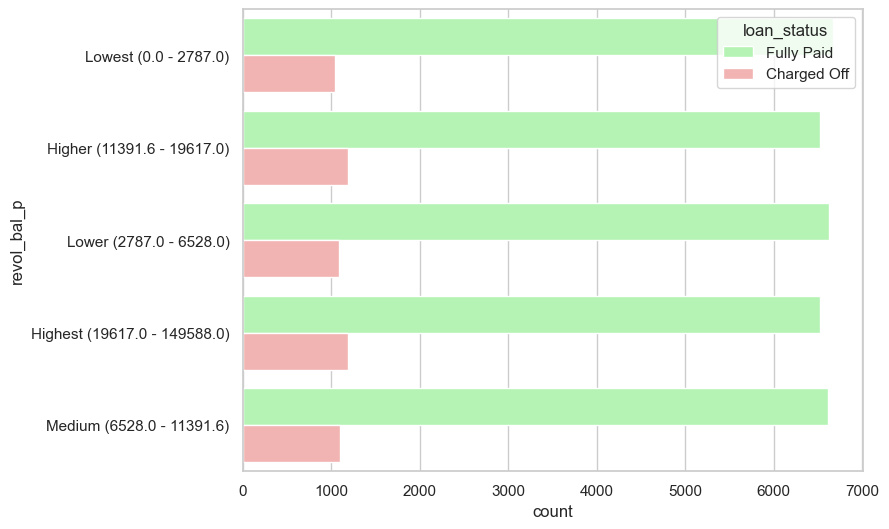

revol_bal_p,Charged off %,Record count
Highest (19617.0 - 149588.0),0.154913,7714
Higher (11391.6 - 19617.0),0.154335,7717
Medium (6528.0 - 11391.6),0.142894,7712
Lower (2787.0 - 6528.0),0.141283,7715
Lowest (0.0 - 2787.0),0.135898,7719


In [216]:
PercentileCut(column='revol_bal')
Univariate_Categorical(column='revol_bal_p')

**Observations**:<br>
-  Looks like most of the revolving credit balance is around 10000
-  This shows the total credit revolving balances very slightly is correlted the default percentage.

#### 8. revol_util
(Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.)

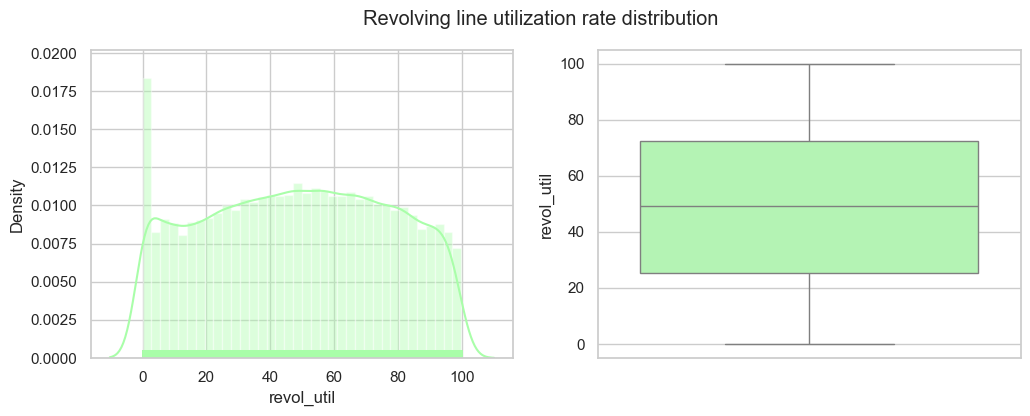

In [221]:
var1 = loan.revol_util

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(a=var1, rug=True)
plt.subplot(1,2,2)
sns.boxplot(data=var1)
plt.suptitle('Revolving line utilization rate distribution')
plt.show()

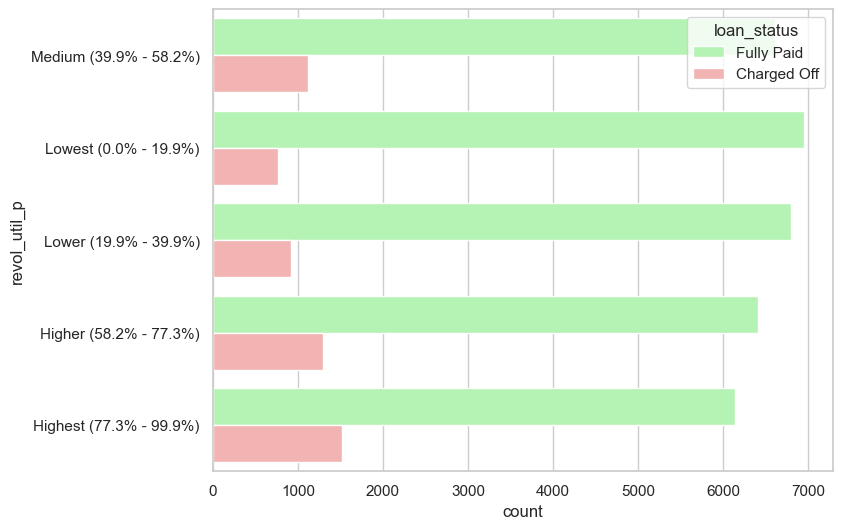

revol_util_p,Charged off %,Record count
Highest (77.3% - 99.9%),0.198069,7664
Higher (58.2% - 77.3%),0.167727,7703
Medium (39.9% - 58.2%),0.145001,7731
Lower (19.9% - 39.9%),0.118356,7714
Lowest (0.0% - 19.9%),0.099417,7715


In [223]:
PercentileCut(column='revol_util',trailer='%')
Univariate_Categorical(column='revol_util_p')

**Observations**:<br>
-  Looks like most of the revolving credit balance is around 10000
-  This data shows that the revolving line utilization rate is highly correlated to the default percentage.

#### 9. term
(The number of payments on the loan. Values are in months and can be either 36 or 60.)

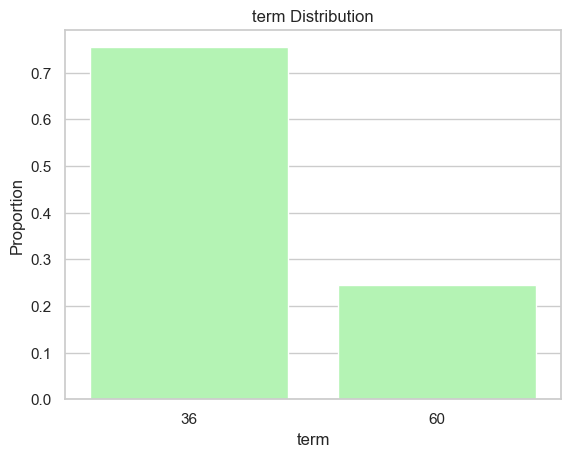

In [247]:
var = 'term'
#Probability / Percentage of each values
prob_df = loan[var].value_counts(normalize=True).reset_index()

sns.barplot(x='term', y='proportion', data=prob_df)
plt.xlabel(var)
plt.ylabel('Proportion')
plt.title(var+' Distribution')
plt.show()

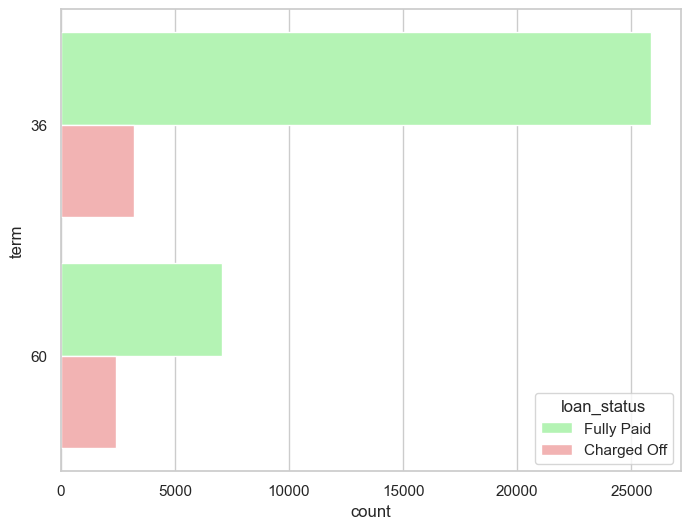

term,Charged off %,Record count
60,0.253138,9481
36,0.110909,29096


In [251]:
Univariate_Categorical(column='term')

**Observations**:<br>
-  Borrowers have taken 36 months tenure more than 60 months.
-   shows that the revolving line utilization rate is highly correlated to the default percentage.

#### 10. grade
(LC assigned loan grade.)

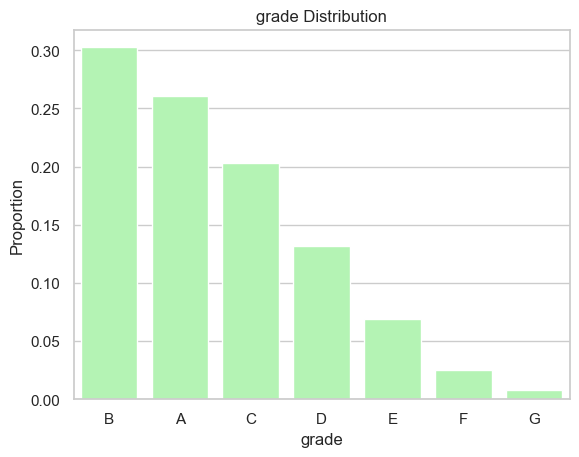

In [259]:
var = 'grade'
#Probability / Percentage of each values
prob_df = loan[var].value_counts(normalize=True).reset_index()

sns.barplot(x=var, y='proportion', data=prob_df)
plt.xlabel(var)
plt.ylabel('Proportion')
plt.title(var+' Distribution')
plt.show()

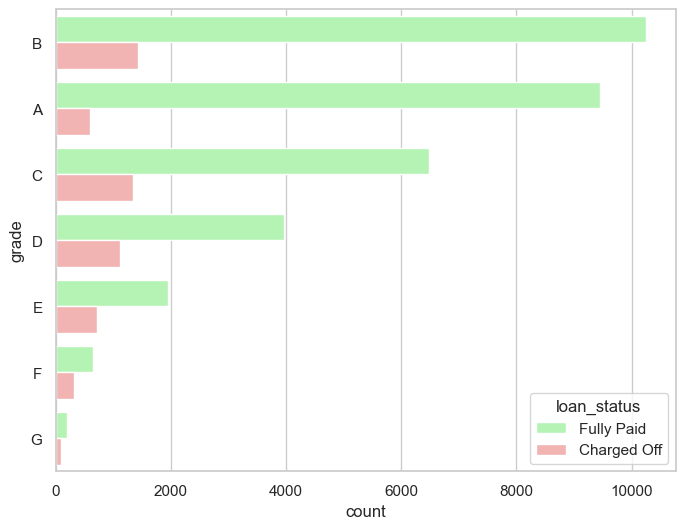

grade,Charged off %,Record count
G,0.337793,299
F,0.326844,976
E,0.268494,2663
D,0.219862,5085
C,0.171943,7834
B,0.122056,11675
A,0.059930,10045


In [261]:
Univariate_Categorical(column='grade')

**Observations**: <br>
-  Most borrowers fall under A and B grades then other grades
-  Borrowers are more likely to default if they are graded G,F,E,D compared to other grades

#### 11. sub-grade
(LC assigned loan subgrade)

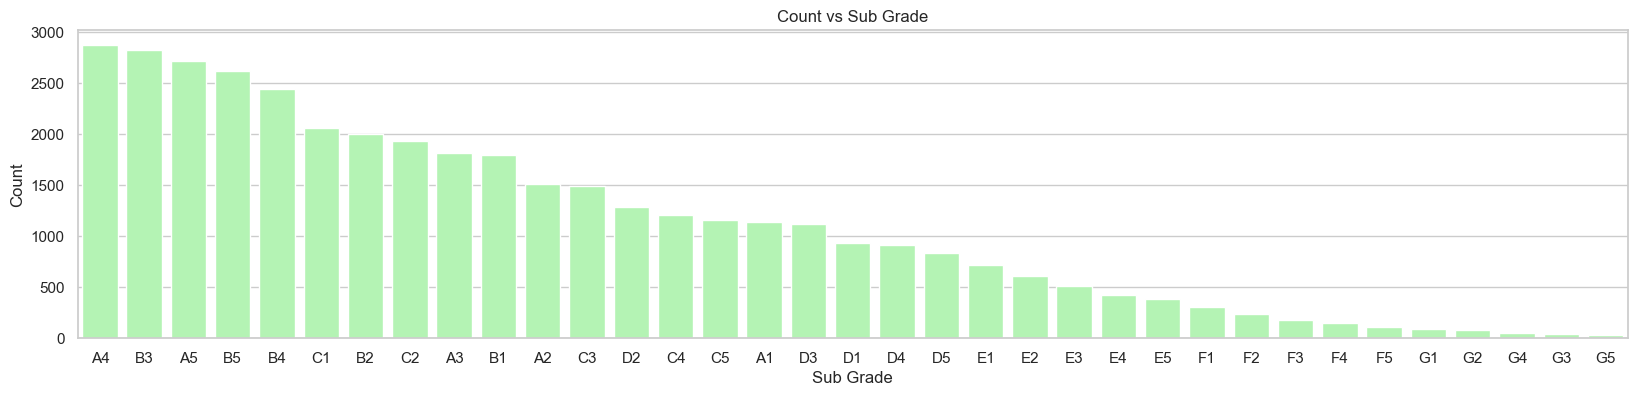

In [269]:
# Set the figure size
plt.figure(figsize=(20, 4))

# Create a vertical count plot
sns.countplot(data=loan, x='sub_grade', order=loan['sub_grade'].value_counts().index)

# Customize the plot
plt.title('Count vs Sub Grade')
plt.xlabel('Sub Grade')
plt.ylabel('Count')

# Show the plot
plt.show()

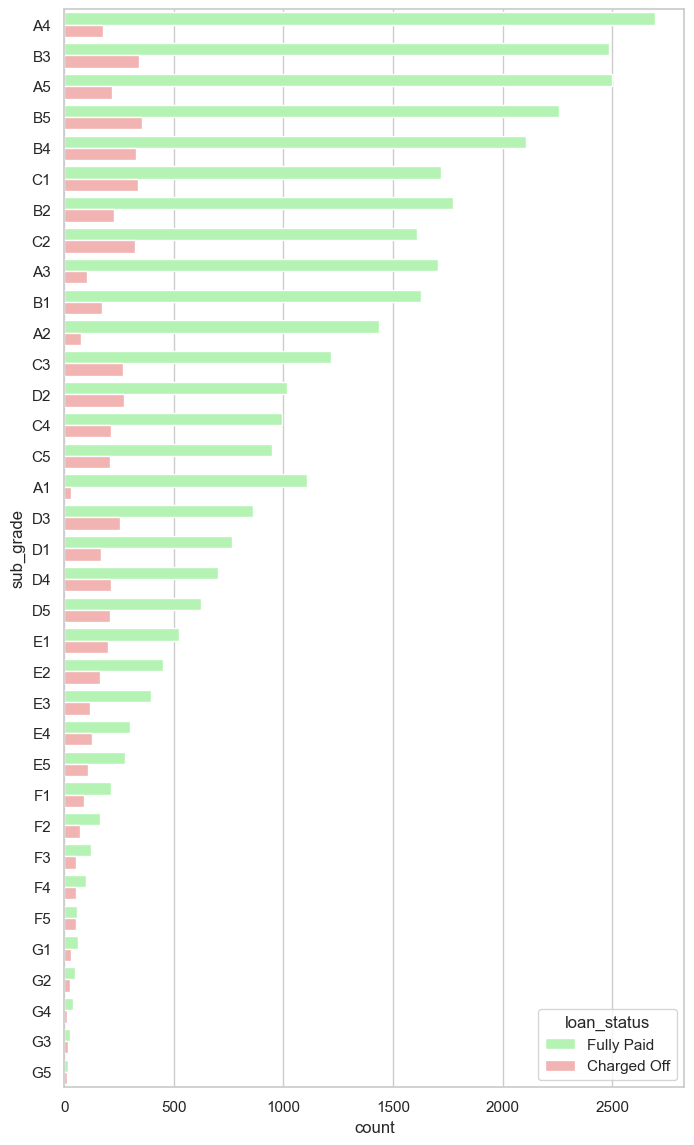

sub_grade,Charged off %,Record count
F5,0.477876,113
G3,0.422222,45
G2,0.363636,77
F4,0.350993,151
G5,0.344828,29
G1,0.329787,94
F2,0.300429,233
F1,0.298361,305
E4,0.297170,424
F3,0.293103,174


In [271]:
Univariate_Categorical(column='sub_grade', figsize=(8,14))

**Observations**: <br>
-  The table above displays the relationship between loan sub-grades and their default percentages. Notably, the G3 and F5 sub-grades have default rates exceeding 40%. This field is a strong indicator of the likelihood of default.

#### 12. emp_length
(Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.)

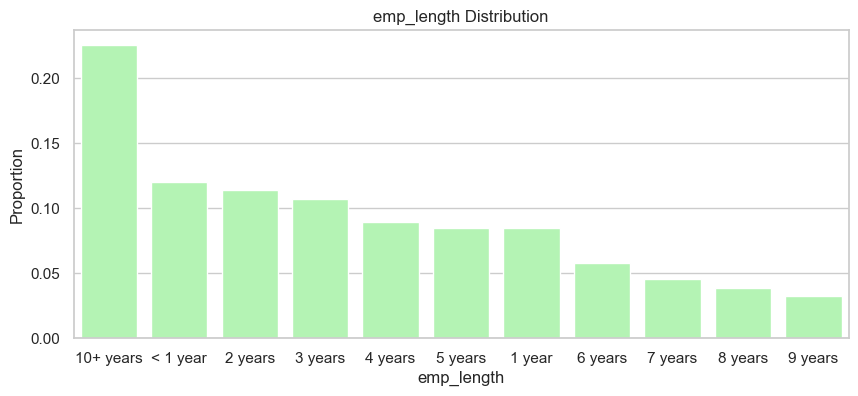

In [292]:
plt.figure(figsize=(10,4))
var = 'emp_length'
#Probability / Percentage of each values
prob_df = loan[var].value_counts(normalize=True).reset_index()

sns.barplot(x=var, y='proportion', data=prob_df)
plt.xlabel(var)
plt.ylabel('Proportion')
plt.title(var+' Distribution')
plt.show()

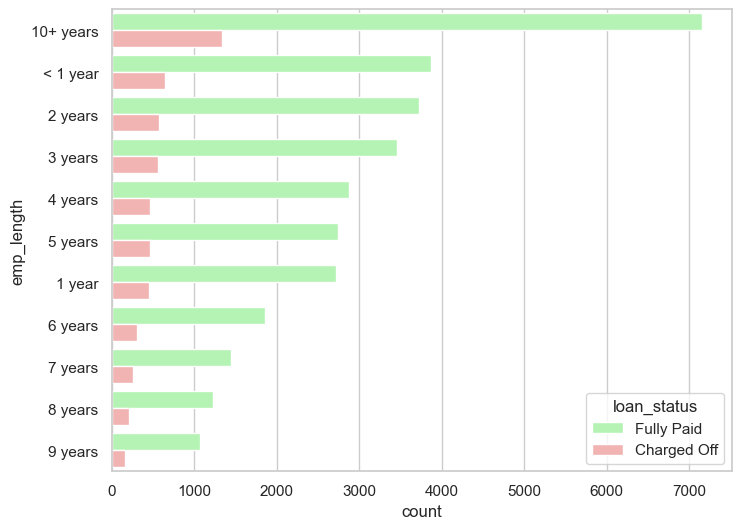

emp_length,Charged off %,Record count
10+ years,0.156810,8488
7 years,0.153711,1711
1 year,0.143894,3169
5 years,0.143394,3194
< 1 year,0.141748,4508
6 years,0.141605,2168
8 years,0.141463,1435
3 years,0.138335,4012
4 years,0.138241,3342
2 years,0.132137,4291


In [294]:
Univariate_Categorical(column='emp_length')


**Observations**:
-  Borrowers are mostly 10+ years emploment length.
-  although there is nothing much to conclude from above data, we can see having no employment will lead to Defaulted payment



#### 13. home_ownership
(The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.)

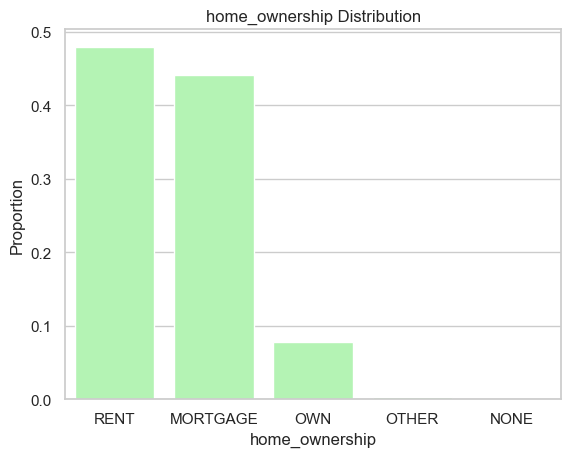

In [307]:
var = 'home_ownership'
#Probability / Percentage of each values
prob_df = loan[var].value_counts(normalize=True).reset_index()
#Plotting percentage proporation vs home ownership
sns.barplot(x=var, y='proportion', data=prob_df)
plt.xlabel(var)
plt.ylabel('Proportion')
plt.title(var+' Distribution')
plt.show()

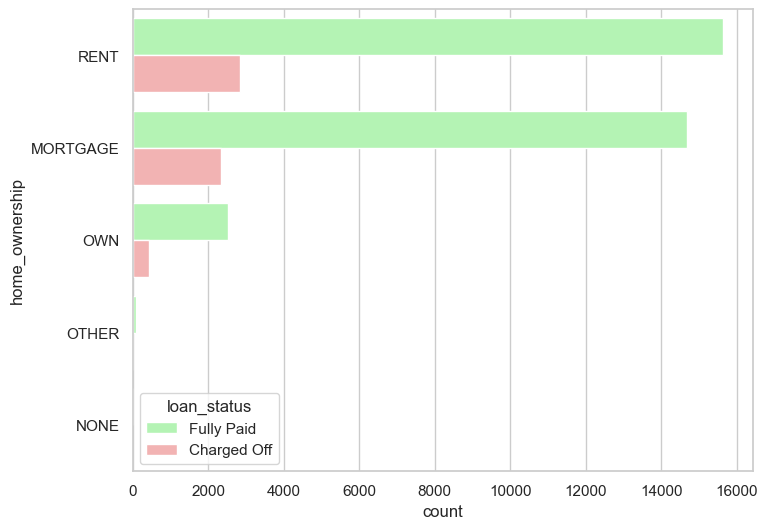

home_ownership,Charged off %,Record count
OTHER,0.183673,98
RENT,0.153626,18480
OWN,0.148908,2975
MORTGAGE,0.136713,17021


In [309]:
Univariate_Categorical(column='home_ownership')


**Observations**:<br>
-  The loan borrowers are mostly having rented and mortgage houses.
-  Looks like people who own a house are less likely to default compared to others


#### 14. verification_status
(Indicates if income was verified by LC, not verified, or if the income source was verified)

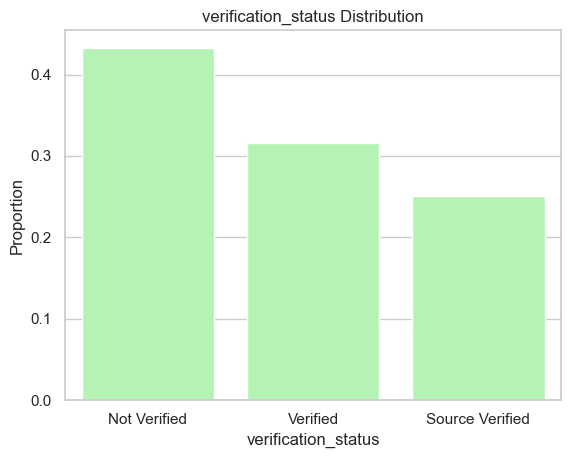

In [320]:
var = 'verification_status'
#Probability / Percentage of each values
prob_df = loan[var].value_counts(normalize=True).reset_index()

sns.barplot(x='verification_status', y='proportion', data=prob_df)
plt.xlabel(var)
plt.ylabel('Proportion')
plt.title(var+' Distribution')
plt.show()

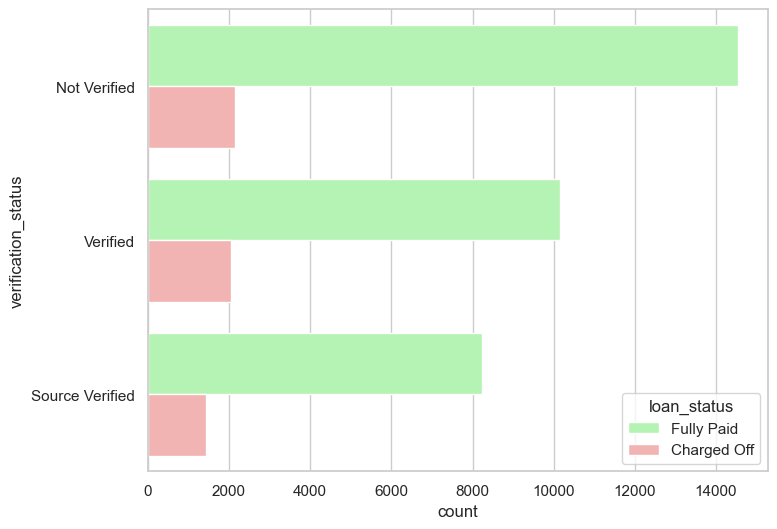

verification_status,Charged off %,Record count
Verified,0.168032,12206
Source Verified,0.148186,9677
Not Verified,0.128310,16694


In [315]:
Univariate_Categorical(column='verification_status')

**Observations**:<br>
-  The majority of loans were given without verification of the applicant's income.
-  Interestingly verified applicants have more defaulted %. 

#### 15. purpose
(A category provided by the borrower for the loan request. )

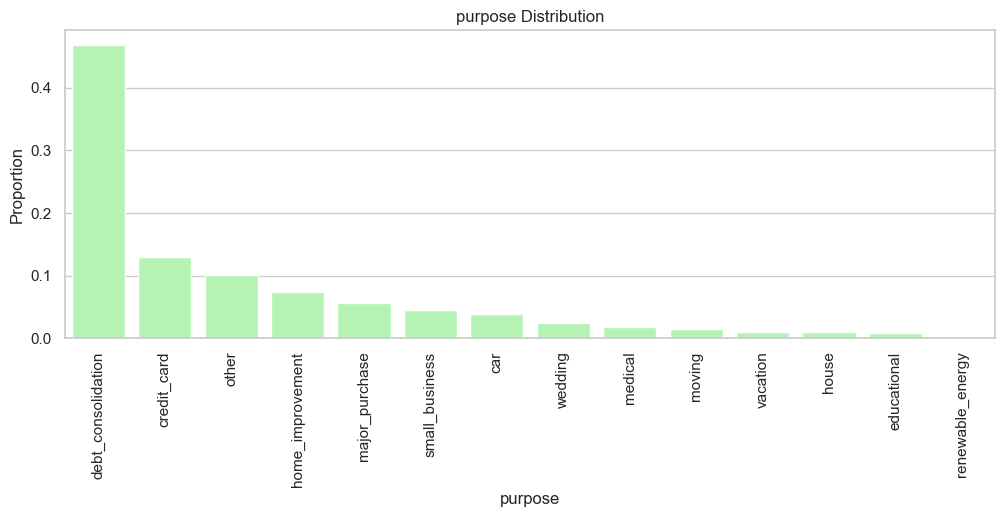

In [327]:
plt.figure(figsize=(12,4))
var = 'purpose'
#Probability / Percentage of each values
prob_df = loan[var].value_counts(normalize=True).reset_index()

sns.barplot(x=var, y='proportion', data=prob_df)
plt.xlabel(var)
plt.xticks(rotation=90)
plt.ylabel('Proportion')
plt.title(var+' Distribution')
plt.show()

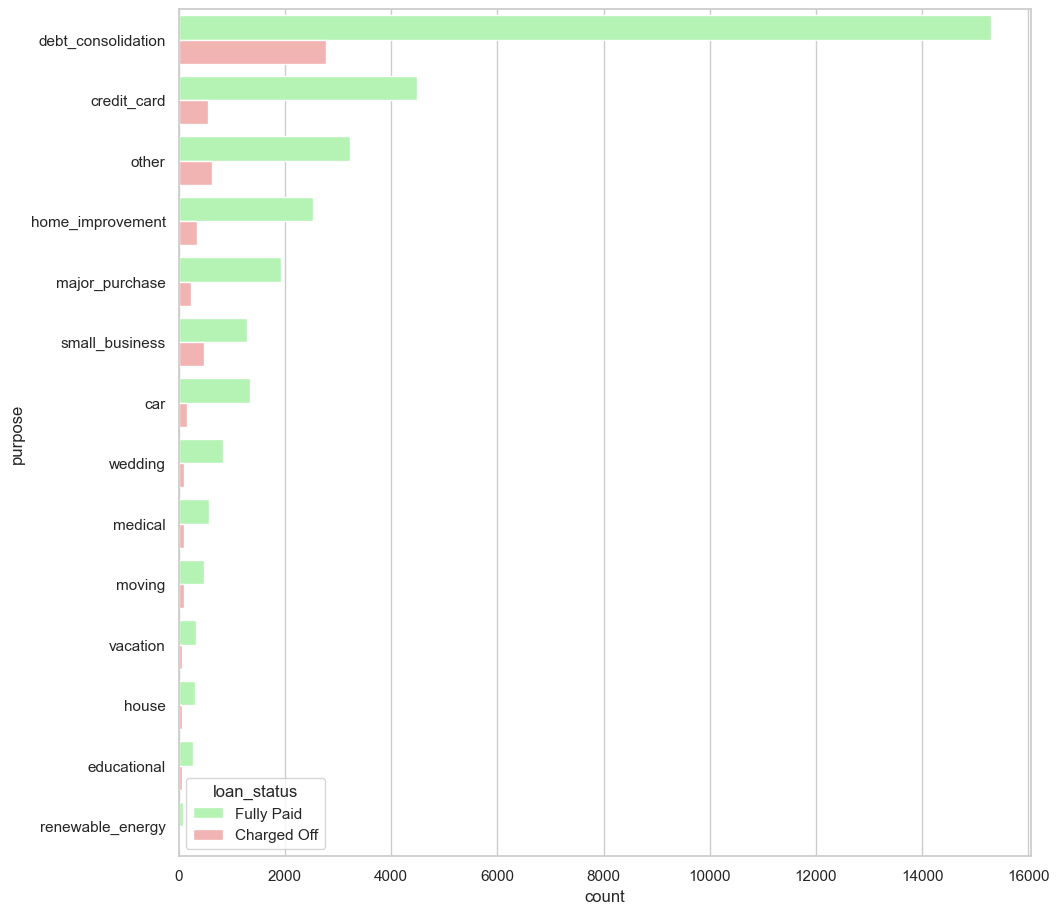

purpose,Charged off %,Record count
small_business,0.270810,1754
renewable_energy,0.186275,102
educational,0.172308,325
other,0.163777,3865
house,0.160763,367
moving,0.159722,576
medical,0.155653,681
debt_consolidation,0.153254,18055
vacation,0.141333,375
home_improvement,0.120696,2875


In [329]:
Univariate_Categorical(column='purpose', figsize=(11,11))

**Observations:**
-  Looks like more number of people took loan for debt consolidation and a very few people took for renewable energy
-  From the above analysis it is evidend that the loans taken for small_business, renewable_energy and educational are the riskier ones.

#### 16. addr_state
(The state provided by the borrower in the loan application)

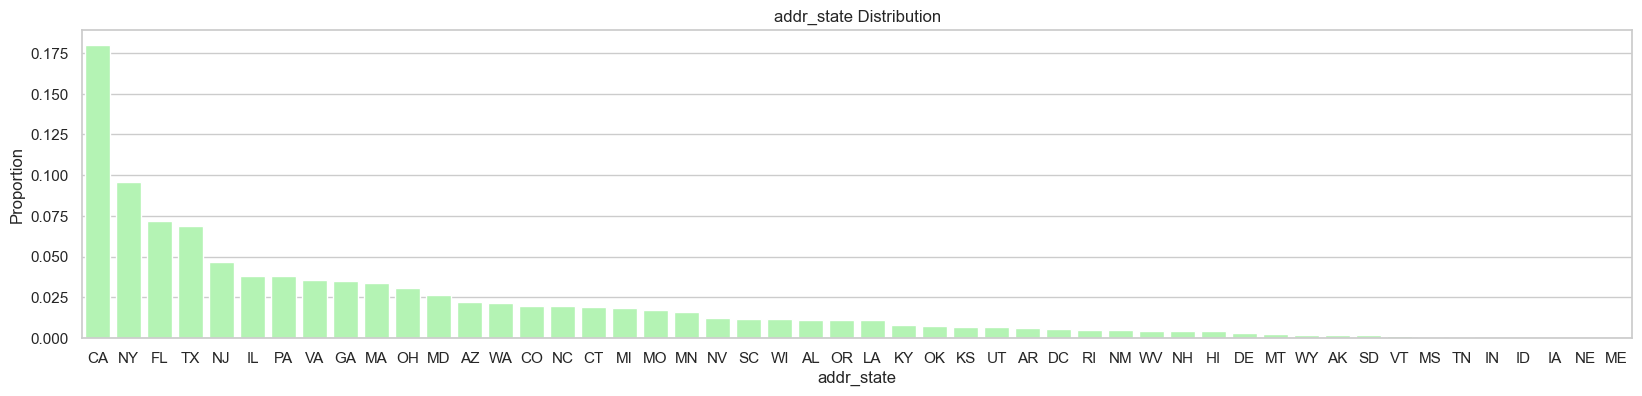

In [338]:
plt.figure(figsize=(20,4))
var = 'addr_state'
#Probability / Percentage of each values
prob_df = loan[var].value_counts(normalize=True).reset_index()

sns.barplot(x='addr_state', y='proportion', data=prob_df)
plt.xlabel(var)
plt.ylabel('Proportion')
plt.title(var+' Distribution')
plt.show()

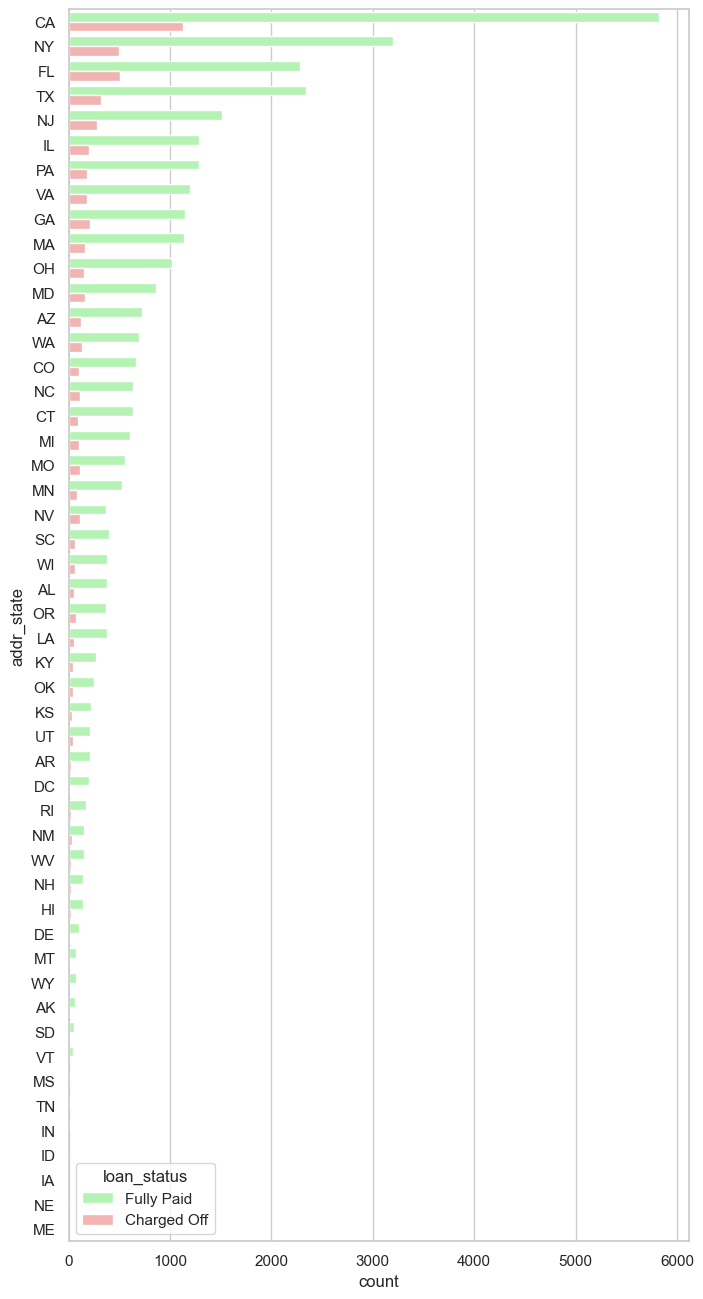

addr_state,Charged off %,Record count
NE,0.600000,5
NV,0.225470,479
SD,0.193548,62
AK,0.192308,78
FL,0.181230,2781
MO,0.170149,670
HI,0.168675,166
ID,0.166667,6
NM,0.163934,183
OR,0.163218,435


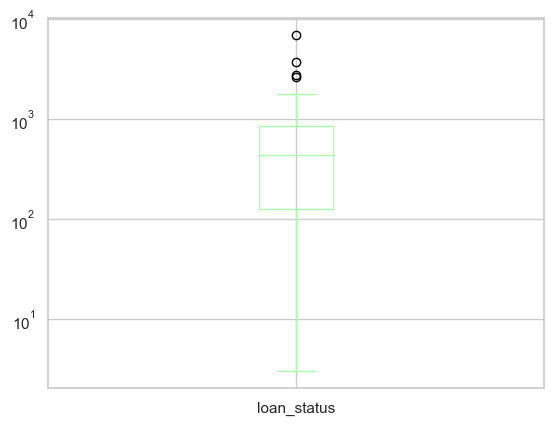

In [340]:
Univariate_Categorical(column='addr_state',figsize=(8,16), box_plot=True)

**Observations:**
-  Most of the borrowers are from CA and NY
-  From the above table we can see that the some of the risky states are NE, NV, SD, AK, FL, MO

#### 17. pub_rec
(Number of Public derogatory records)

Text(0.5, 1.0, 'pub_rec Distribution')

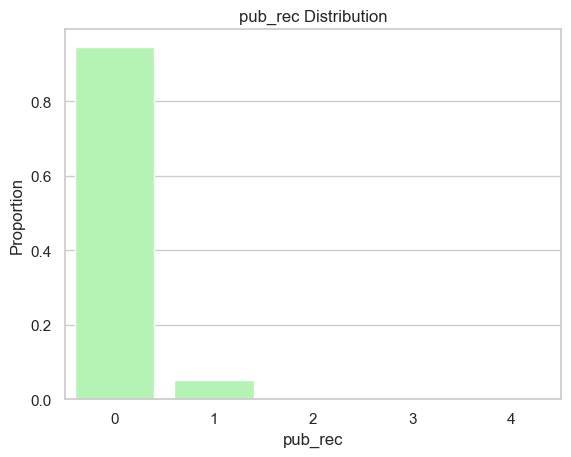

In [345]:
var = 'pub_rec'
#Probability / Percentage of each values
prob_df = loan[var].value_counts(normalize=True).reset_index()
sns.barplot(x='pub_rec', y='proportion', data=prob_df)
plt.xlabel(var)
plt.ylabel('Proportion')
plt.title(var+' Distribution')

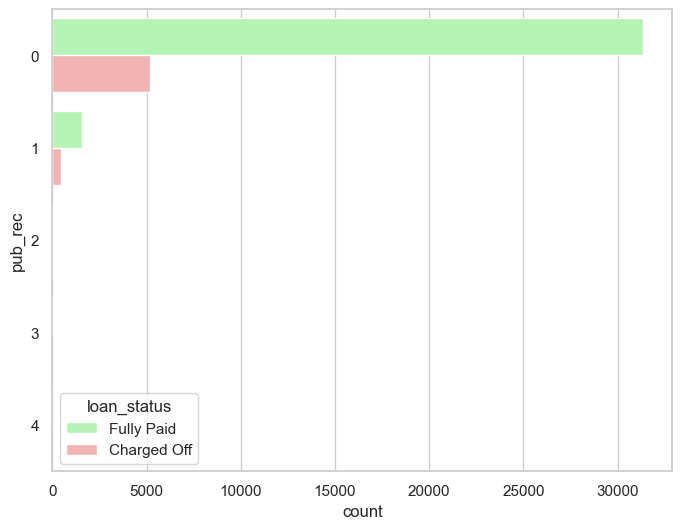

pub_rec,Charged off %,Record count
1,0.227024,2013
2,0.208333,48
0,0.141343,36507


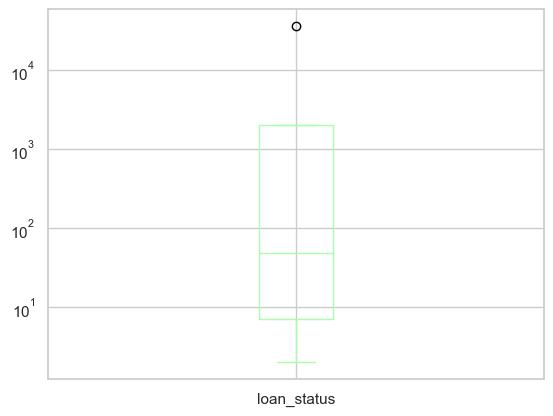

In [347]:
Univariate_Categorical(column='pub_rec', box_plot=True)

**Observations**<br>
-  Around 90% borrower's are having no public derogatory records.
-  Above data and graph cleary shows that individuals with non-zero derogatory public records have higher chances of defaulting


#### 18. pub_rec_bankruptcies
(Number of public record bankruptcies)

Text(0.5, 1.0, 'pub_rec_bankruptcies Distribution')

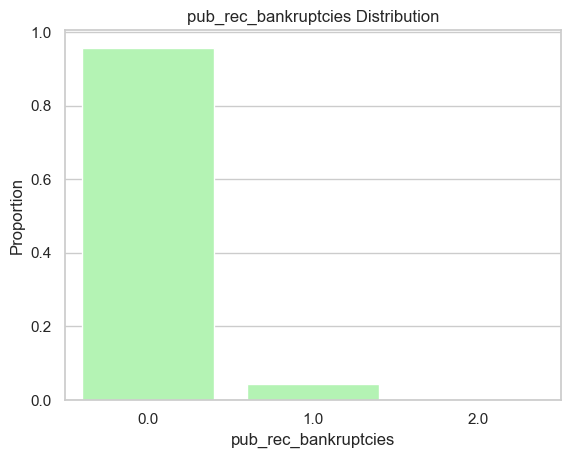

In [352]:
var = 'pub_rec_bankruptcies'
#Probability / Percentage of each values
prob_df = loan[var].value_counts(normalize=True).reset_index()
sns.barplot(x='pub_rec_bankruptcies', y='proportion', data=prob_df)
plt.xlabel(var)
plt.ylabel('Proportion')
plt.title(var+' Distribution')

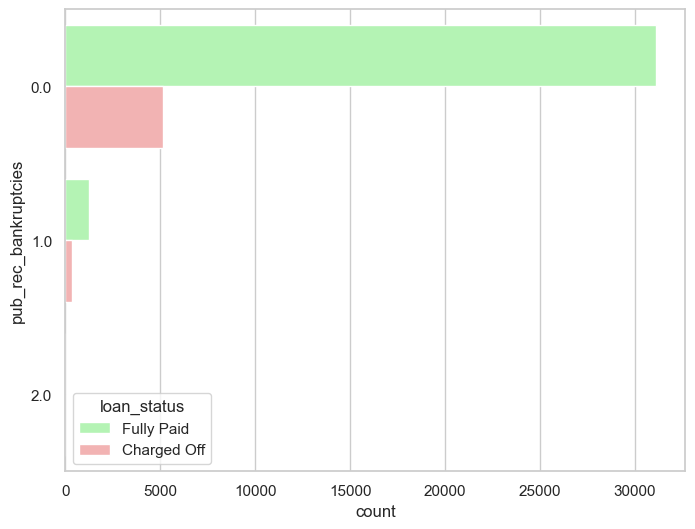

pub_rec_bankruptcies,Charged off %,Record count
2.0,0.400000,5
1.0,0.223580,1637
0.0,0.141868,36238


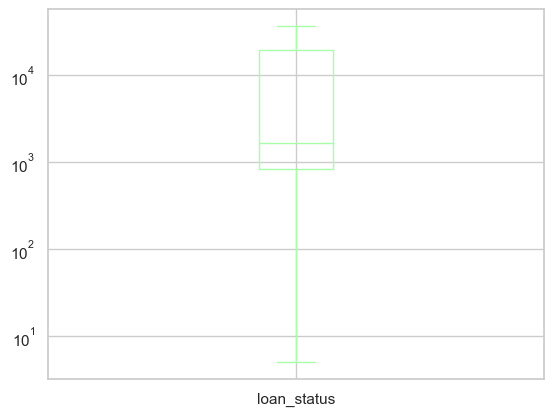

In [354]:
Univariate_Categorical(column='pub_rec_bankruptcies', box_plot=True)

**Observations:**
-  99% people have not went bankrupt
-  Higher the number of public bankruptcy records, bigger the chance of defaulting the loan.

#### 19. issue_d
(The month which the loan was funded)

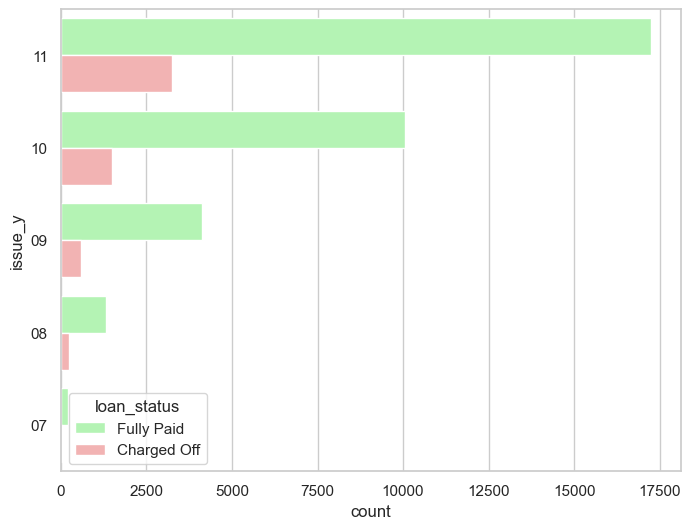

issue_y,Charged off %,Record count
07,0.179283,251
11,0.158705,20516
08,0.158131,1562
10,0.128772,11532
09,0.125954,4716


In [362]:
# We'll do year wise plotting first
Univariate_Categorical(column='issue_y')

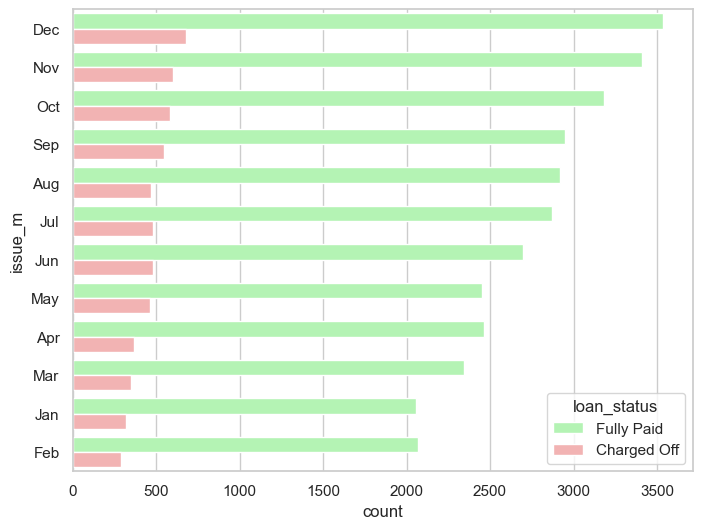

issue_m,Charged off %,Record count
Dec,0.160854,4215
May,0.159644,2919
Sep,0.156375,3498
Oct,0.154214,3761
Jun,0.151887,3180
Nov,0.149276,4006
Jul,0.142942,3351
Aug,0.138135,3388
Jan,0.134931,2379
Apr,0.130696,2831


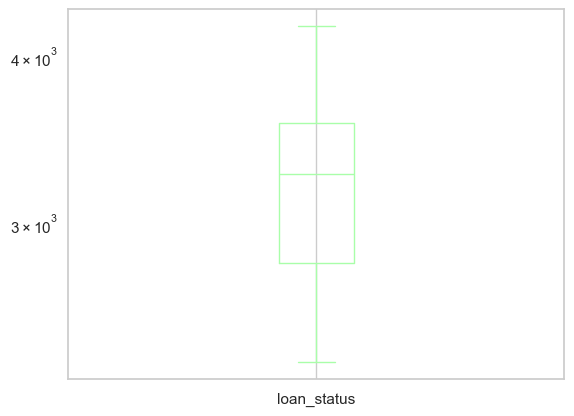

In [364]:
# Month wise data plotting
Univariate_Categorical(column='issue_m', box_plot=True)

"\nvar = 'issue_d_weekday'\n#Probability / Percentage of each values\nprob_df = loan[var].value_counts(normalize=True).reset_index()\nplt.subplot(2,2,3)\nsns.barplot(x='index', y='proportion', data=prob_df)\nplt.xlabel(var)\nplt.ylabel('Proportion')\nplt.title(var+' Distribution')\n\nplt.show()\n"

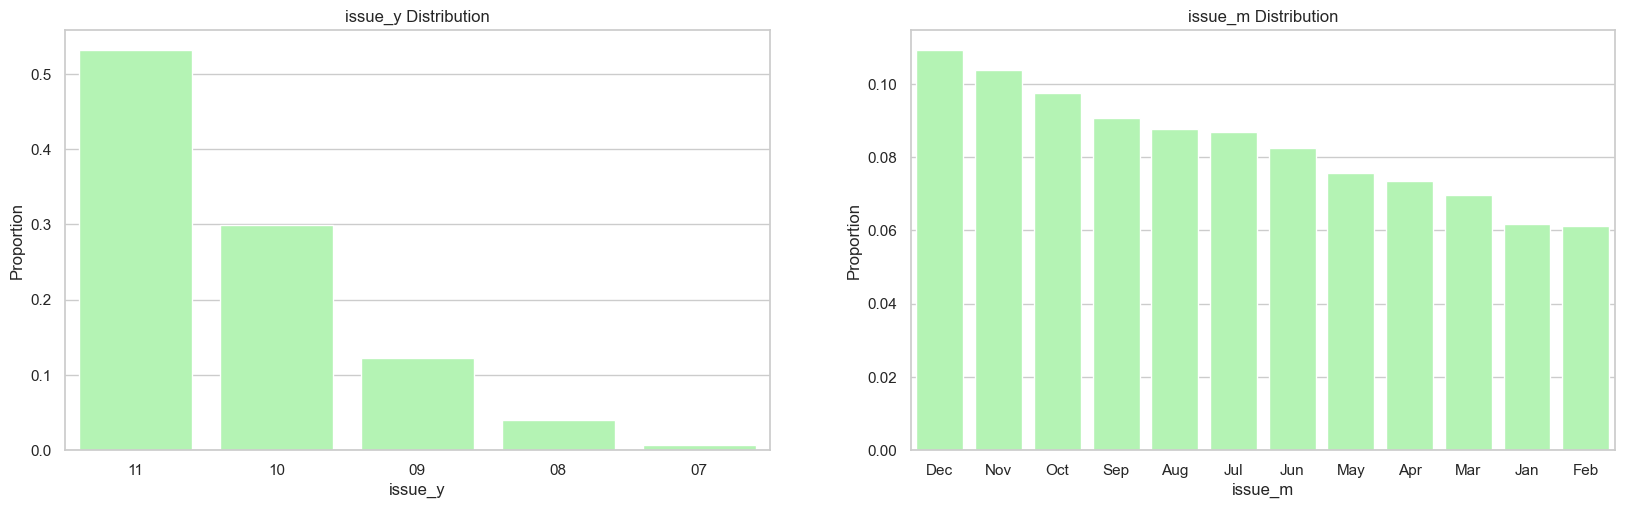

In [374]:
var = 'issue_y'
#Probability / Percentage of each values
prob_df = loan[var].value_counts(normalize=True).reset_index()

plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
sns.barplot(x='issue_y', y='proportion', data=prob_df)
plt.xlabel(var)
plt.ylabel('Proportion')
plt.title(var+' Distribution')

var = 'issue_m'
#Probability / Percentage of each values
prob_df = loan[var].value_counts(normalize=True).reset_index()
plt.subplot(2,2,2)
sns.barplot(x='issue_m', y='proportion', data=prob_df)
plt.xlabel(var)
plt.ylabel('Proportion')
plt.title(var+' Distribution')


**Observations:**
-  It is evident that December has the highest number of loan applications each year and also exhibits the highest default ratio. This may be due to people taking out loans for travel or festivities during the Christmas season and subsequently struggling to repay them. Additionally, May stands out as another peak month, coinciding with summer vacations and major U.S. holidays like Memorial Day and Independence Day, when people are inclined to travel.
-  The lending club(LC) has doubling loan issues every year
-  There are more issues of loan in last 3 months every end of the ear i.e., Oct, Nov and Dec.

### Bivariate Analysis

Now that we have analyzed each of the variables and its impact on the loan-status, let us take group of variables together and and analyze their combined effect on the loan-status. These categories are based on our business understanding. The original distribution column shows the average trend in all the data and we compare that with the data after applying our conditions.

In [379]:
# The function generates a violin plot to explore the distribution of a numerical variable across different categories of a categorical variable.
# This type of plot helps in understanding the distribution,density, and variation of the numerical data within each category.

def Bivariate_Analysis (*, data=loan, x, y, title=None, figsize=(8,6)):
    """
        Parameters:
            data : defaulted at the 'loan' variable, but can be changed externally if needed
            x, y : columns of data in the corresponding axis, one numerical and one categorical
            figsize : a default have is given, but can be overridden
        Returns:
            None, does a violin plot
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.violinplot(data=data, x=x, y=y, hue=by, split=True, figsize=figsize,
                   ax=ax, hue_order=order)
    if title is not None:
        plt.title(title)
    plt.show()

In [381]:
# The function generates a heatmap to show the distribution or frequency of occurrences between two categorical variables. 
# This can help in understanding how the frequency of one categorical variable varies with the categories of another.

def Bivariate_Categorical (*, data=loan, x, y, title=None, figsize=(8,6)):
    """
        Parameters:
            data : defaulted at the 'loan' variable, but can be changed externally if needed
            x, y : columns of data in the corresponding axis, both categorical
            figsize : a default have is given, but can be overridden
        Returns:
            None, does a heatmap plot
    """
    fig, ax = plt.subplots(figsize=figsize)
    pt = pd.pivot_table(data=data, values='loan_status_num', index=y, columns=x)
    sns.heatmap(pt, ax=ax, cmap='YlGnBu')
    if title is not None:
        plt.title(title)
    plt.show()

#### 1. Purpose v/s home_ownership


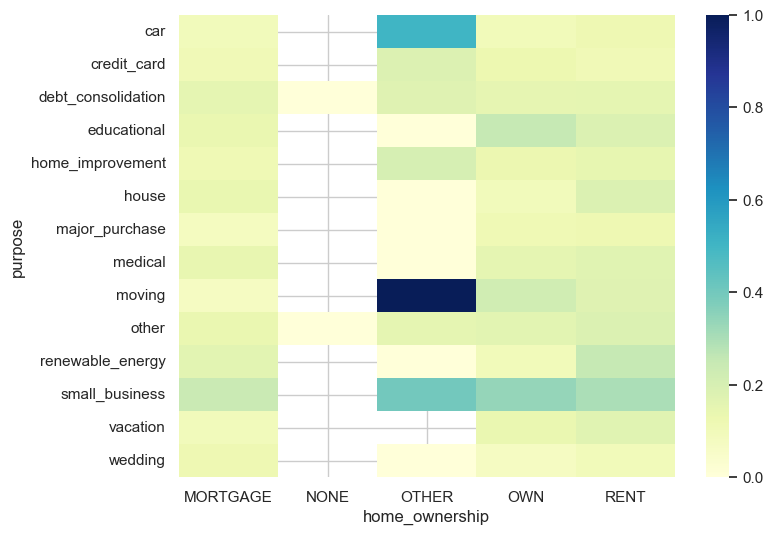

In [385]:
Bivariate_Categorical(x='home_ownership', y='purpose')

#### 2. Address_state v/s Purpose


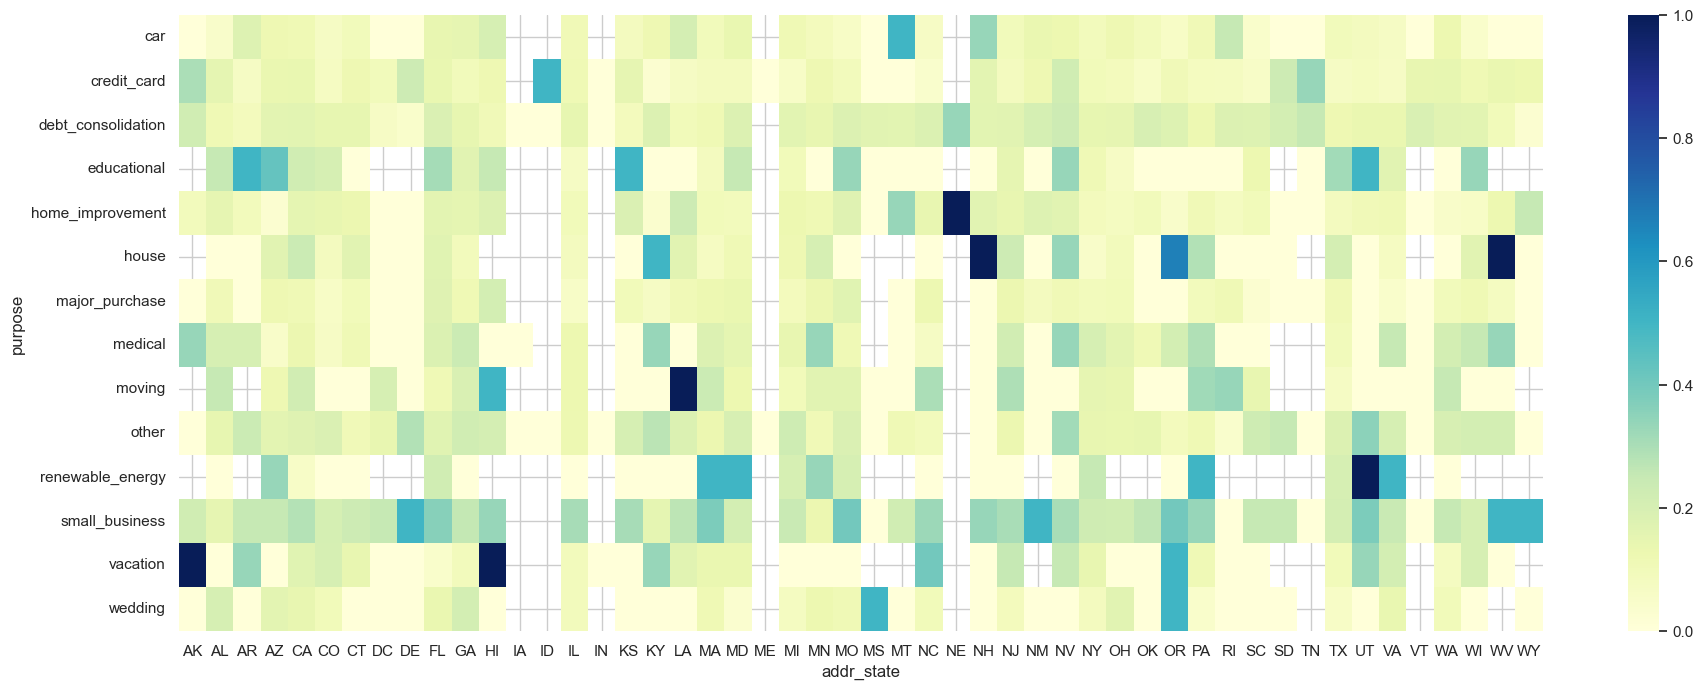

In [387]:
Bivariate_Categorical(x='addr_state', y='purpose', figsize=(22,8))

As per the above plot, the darker the intersection of addr_state has with the purpose of the loan, the risker the loan application is. Some of the examples are below:
-  vacation loans in AK, HI, OR
-  education loans in AR, KS, UT
-  small business loans in DE, NM, WV, wY
-  wedding loans in MS, OR

#### 3. Purpose v/s Annual Inc categories

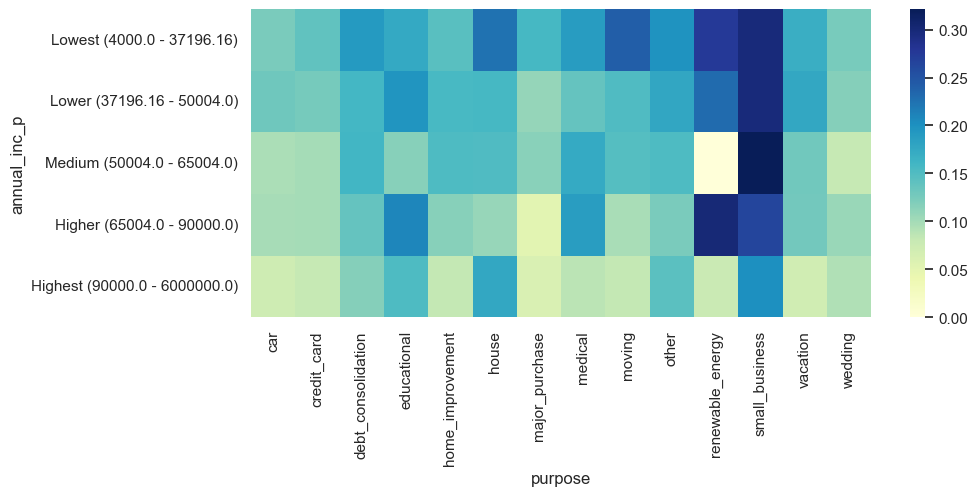

In [395]:
Bivariate_Categorical(x='purpose', y='annual_inc_p', figsize=(10,4))

- From the above heat map we understand that borrowers with lowest income group are more likely to default than higher income earners.
-  We see that small businesses and renewable energy are purposes for which borrowers are more likely to default and are therefore the riskier segments identified.

#### 4. DTI categories v/s Annual income categories

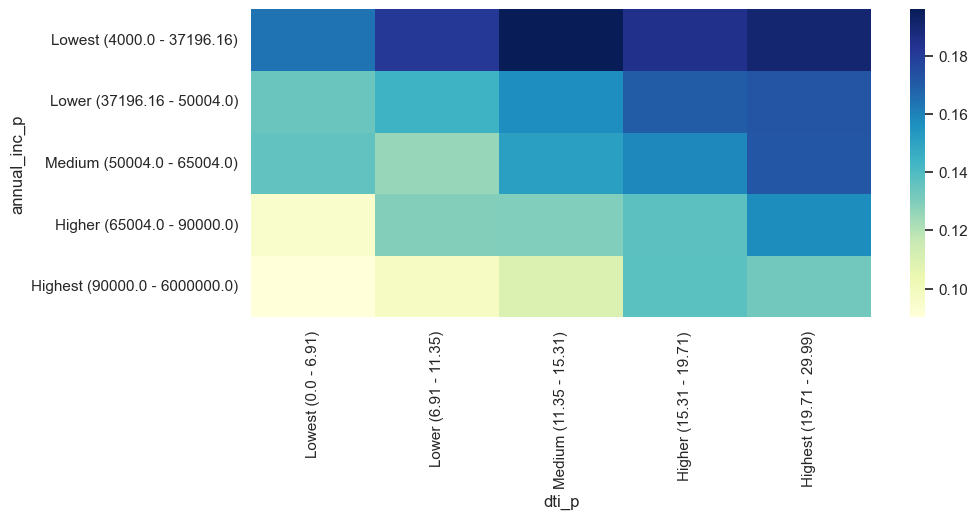

In [401]:
Bivariate_Categorical(x='dti_p', y='annual_inc_p', figsize=(10,4))

Medium debt-to-income group in the lowest income range is the most risky when it comes to loan repayment.
Hereby we come to an end of the EDA of the loan data set and finding some of the drivers for loan default. Below are the details provided in the form of Minor Impact, Heavy Impact and Combined Impact.

#### 1. Highly Influential Factors<br>
These factors have a significant impact on the likelihood of loan default:<br>

**Interest Rate**: Higher interest rates (above 13%) strongly correlate with increased default rates.<br>
**Revolving Line Utilization Rate**: Utilization rates above 58% are strongly associated with higher default risks.<br>
**Repayment Term**: Loans with a 5-year repayment term show a higher likelihood of default.<br>
**Loan Grade & Sub-Grade:** Loans with grades and sub-grades from D to G have a notably higher default rate.<br>
**Missing Employment Record:** The absence of an employment record significantly increases the risk of default.<br>
**Loan Purpose:** Certain purposes like small business loans, renewable energy projects, and educational loans are linked with higher default rates.<br>
**Derogatory Public Records:** Having 1 or 2 derogatory records raises the default risk.<br>
**Public Bankruptcy Records:** The presence of 1 or 2 bankruptcy records is a strong indicator of potential default.<br>

#### 2. Moderately Influential Factors<br>
These factors also impact the likelihood of default, though their effect is less pronounced than the highly influential factors:<br>

**Loan Amount:** Larger loan amounts (above 16,000) are associated with higher default risk.<br>
**Installment Amount:** Higher installment amounts (above 327) can increase the probability of default.<br>
**Annual Income:** Lower annual incomes (below 37,000) contribute to a higher default risk.<br>
**Debt-to-Income Ratio:** A higher debt-to-income ratio (above 15%) correlates with an increased likelihood of default.<br>
**Residential State:** Certain states such as NV, SD, AK, FL, etc., show higher default rates.<br>
**Loan Issuance Month:** Loans issued in December, May, and September tend to have higher default rates.<br>

#### 3. Combined Impact Factors<br>
These factors have an amplified effect on default risk when considered in combination:<br>

**High Loan Amount & High Interest Rate:** Particularly risky for lower income groups. Combining a large loan amount with a high interest rate significantly increases default likelihood.<br>
**High Installment & Longer Repayment Term:** A combination of high monthly installments and a longer repayment term can be particularly risky.<br>
**Home Ownership Status & Loan Purpose:** Loans where home ownership is categorized as ‘other’ and purposes include car purchases, moving, or small businesses exhibit higher default risks.<br>
**Residential State & Loan Purpose:** The interplay between the state of residence and the loan purpose influences default risk.<br>
**Income Group & Loan Purpose:** The relationship between income levels and loan purposes can affect the likelihood of default.<br>

The most critical factors influencing loan default include high interest rates, high revolving line utilization rates, long repayment terms, lower loan grades, missing employment records, and specific loan purposes. Additionally, larger loan amounts, higher installment payments, lower annual incomes, and higher debt-to-income ratios also contribute to default risk. Certain combinations of these factors, such as high loan amounts with high interest rates or high installments with longer terms, further amplify the risk.